# Approximating Fluxes for Particle-Laden Flow

Setting up code & defining parameters

In [ ]:
#pip install cvxopt
#pip install matplotlib
#pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
%reset -f
# Reset
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.integrate import simpson
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import curve_fit
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp
%matplotlib inline

### Base Parameters
phi_m = 0.61
K_v = 0.62
K_c = 0.41
mu_l = 10**(-3)*971 # L2
rho_l = 971 # varies with liquid L2
rho_p = 2475 # fixed for the same type of particle
rho_s = (rho_p - rho_l)/rho_l
B1 = 2*(K_v - K_c)/K_c

### Parameters of Choice
alphadeg = 25
alpha = alphadeg*np.pi/180
cot = lambda x: np.cos(x)/np.sin(x)
B2 = 2*rho_s*cot(alpha)/(9*K_c)
phi_q = -(B2+1)/(2*rho_s) + np.sqrt((B2+1)**2 + 4*B2*rho_s)/(2*rho_s)
phi_c =  min([phi_m, phi_q])
print("The value of B2 is given by ", B2)
# print("The value of phi_q is given by ", phi_q)
print("The value of phi_c is given by ", phi_c)

### Update the corresponding flux functions
F = lambda z,phi,sigma: 1/sigma*(-B2 + (B2+1)*phi + rho_s*phi**2)/(1 + B1*phi/(phi_m - phi))*np.heaviside(phi,0)*np.heaviside(phi_m-phi,0)
G = lambda z,phi,sigma: -(1+rho_s*phi)
FF = lambda z,para: np.array([F(z,para[0],para[1]),G(z,para[0],para[1])])
# para here refers to a vectorized parameter, with para = [phi,sigma]; FF here is also vectorized.

The value of B2 is given by  1.800361378874279
The value of phi_c is given by  0.5029745898440248


In [37]:
plt.figure(figsize = (10, 8))
phi_0sto = []
f_fluxsto = []
g_fluxsto = []

gap = 0.001 # Step size for phi_0
overallrtol = 5e-4
overallatol = 1e-6
t_con = 0.8**(1/10)
t_evalfine = np.concatenate((np.linspace(0,t_con,20001,endpoint=False),np.linspace(0.8,1,80001)**(1/10)))

### Integrating all

start_time = time.monotonic()

for ind in range(0,611):
  phi_0 = ind*gap
  if ind%10 == 0:
    print(ind)
  sigma0 = 1 + rho_s*phi_0
  phi0left = 0
  phi0right = phi_m
  med = 'Radau'
  for j in range(0,20):
    phi0mid = 1/2*(phi0left + phi0right)
    sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol)
    checker = sol.y[1][-1]
    if checker > 0:
      phi0left = phi0mid
    if checker < 0:
      phi0right = phi0mid
  sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol)

  ### Get true numerical integrals
  sigmas = sol.y[1]
  phis = sol.y[0]
  times = sol.t

  integrands = mu_l*sigmas*(1-phis/phi_m)**2
  utrue = np.array([0,])
  utrue = np.append(utrue,cumulative_trapezoid(integrands,times))
  uphitrue = np.array(utrue)*np.array(phis)
  g_flux = simpson(uphitrue,x=times)
  f_flux = simpson(utrue,x=times)
  phi_0sto.append(phi_0)
  f_fluxsto.append(f_flux)
  g_fluxsto.append(g_flux)


end_time = time.monotonic()

print("\n Time Elapsed: ", end_time - start_time, " seconds" )

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610

 Time Elapsed:  152.94307359994855  seconds


<Figure size 1000x800 with 0 Axes>

In [ ]:
#################################
### Flux File Management
#################################
import pickle

### For simplicity, run both codes for "saving" and "loading" - 
###   you will also create a new variables named f_flux_30 and g_flux_30, copying the stored flux values 
###   from f_flux_sto and g_flux_sto, UNLESS you just want to load!

### Saving

#with open("f_flux_25", "wb") as f_flux_25:
#  pickle.dump(f_fluxsto, f_flux_25)

#with open("g_flux_25", "wb") as g_flux_25:
#  pickle.dump(g_fluxsto, g_flux_25)

### Loading

with open("f_flux_25", "rb") as f_flux_25:
  f_flux_25 = pickle.load(f_flux_25)

with open("g_flux_25", "rb") as g_flux_25:
  g_flux_25 = pickle.load(g_flux_25)

### If file is loaded directly without running the flux generation code, run these too:

gap = 0.001  
phi_0sto = np.linspace(0,0.61,611)


In [39]:
## Second order flux-interpolation function
## Include ghost points to convert second-order interpolation to first-order at boundary points; see remark in Section 7.1
f_left_append = f_flux_25[0] - 3*f_flux_25[1] + 3*f_flux_25[2]
f_right_append = f_flux_25[-3] - 3*f_flux_25[-2] + 3*f_flux_25[-1]
g_left_append = g_flux_25[0] - 3*g_flux_25[1] + 3*g_flux_25[2]
g_right_append = g_flux_25[-3] - 3*g_flux_25[-2] + 3*g_flux_25[-1]
f_flux_25 = [f_left_append] + f_flux_25 + [f_right_append]
g_flux_25 = [g_left_append] + g_flux_25 + [g_right_append]
## DO THIS ONLY ONCE!

Finite difference approximation of derivatives at grid points:

$$f'_i = \frac{1}{2(\Delta \phi_0)}\left( -f_{i-1} + f_{i+1} \right)$$
$$f''_i = \frac{1}{(\Delta \phi_0)^2}\left( f_{i-1} - 2f_i + f_{i+1} \right)$$

Note that these are only valid at interior grid points

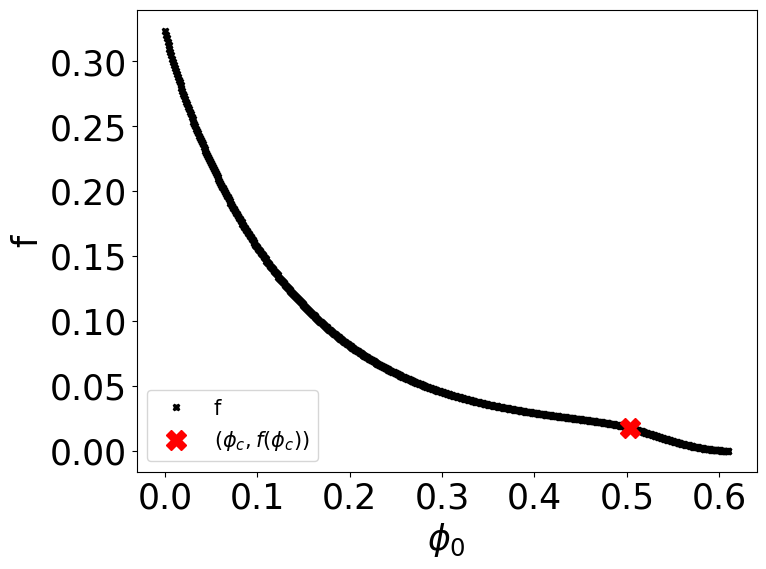

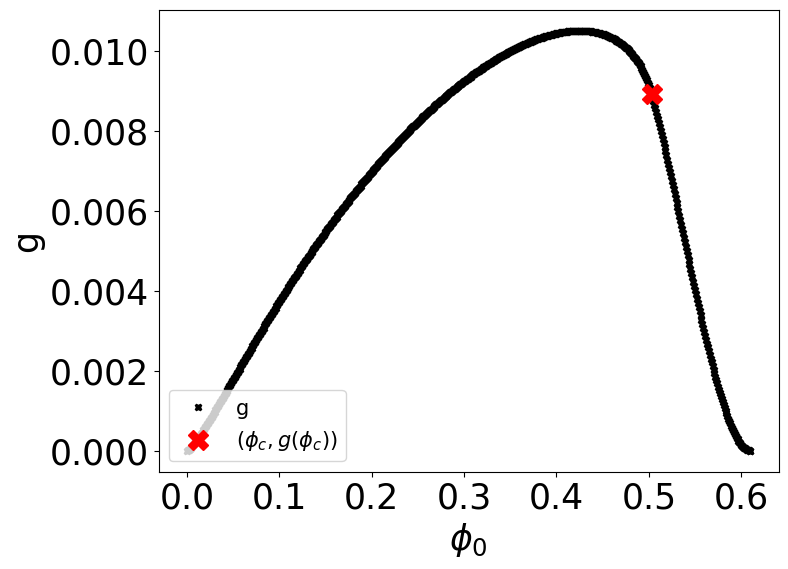

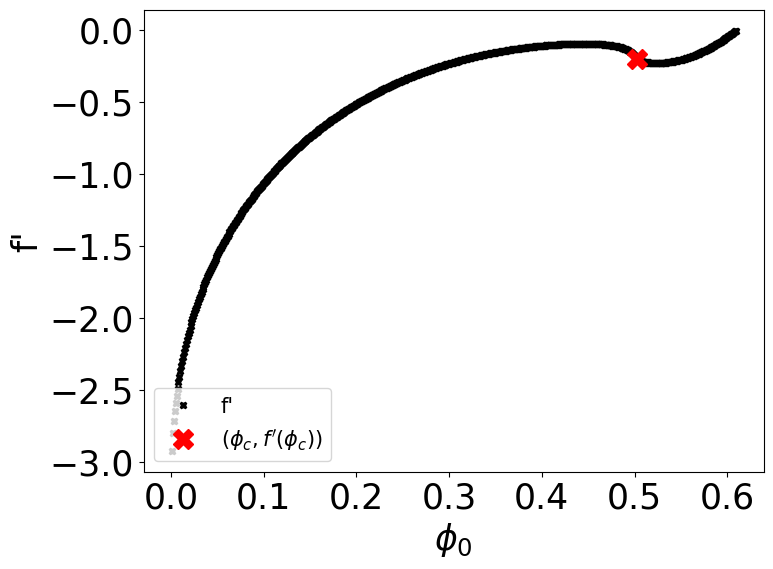

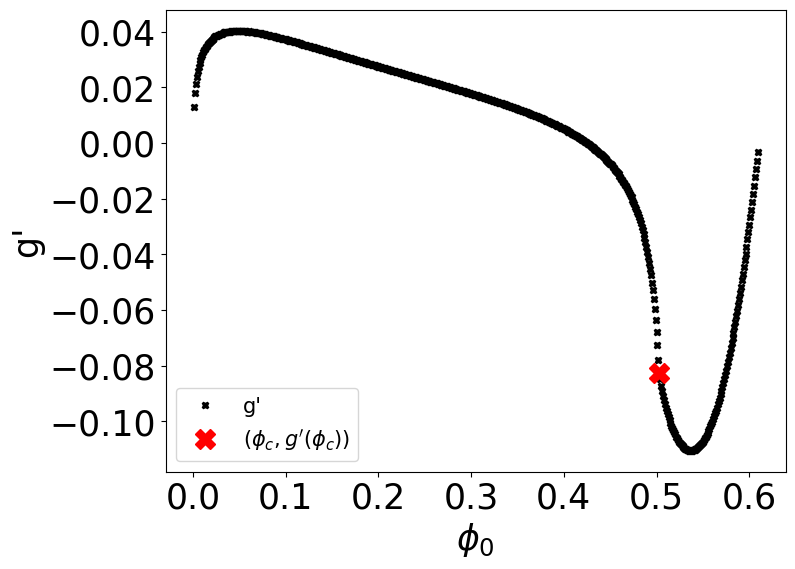

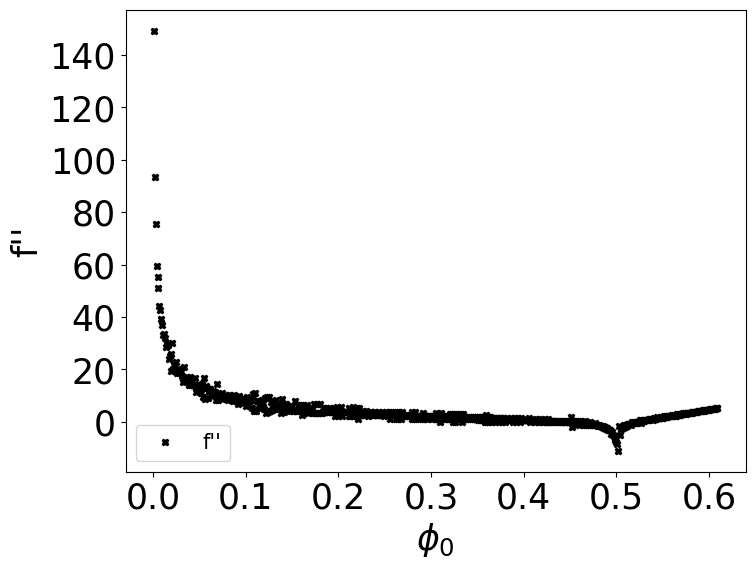

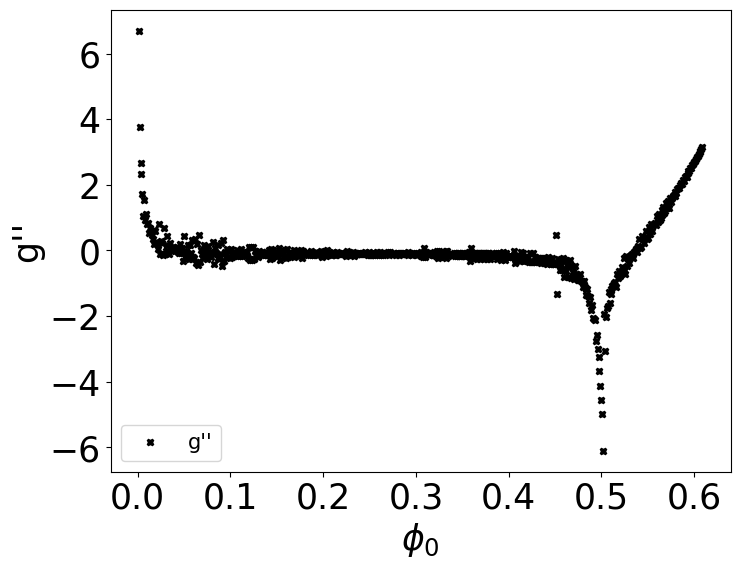

In [41]:
##################################
### Plots of Flux Functions
##################################

f_flux_25 = np.array(f_flux_25)
g_flux_25 = np.array(g_flux_25)
f_val = f_flux_25[1:-1]
g_val = g_flux_25[1:-1]
fp_val = 1/(2*gap)*(-f_val[:-2] + f_val[2:])
fpp_val = 1/(gap**2)*(f_val[:-2] - 2*f_val[1:-1] + f_val[2:])
gp_val = 1/(2*gap)*(-g_val[:-2] + g_val[2:])
gpp_val = 1/(gap**2)*(g_val[:-2] - 2*g_val[1:-1] + g_val[2:])
phi_0sto1 = phi_0sto[1:-1]

A1 = (B2+1+2*rho_s*phi_c)/((1+rho_s*phi_c)*(phi_m+(B1-1)*phi_c))*(phi_m - phi_c)
C = 1 - A1
fc = mu_l/3*(1+rho_s*phi_c)*(1-phi_c/phi_m)**2
gc = phi_c*fc
fcp = mu_l/(C+2)*(rho_s*(1-phi_c/phi_m)**2 - 2*C*(1+rho_s*phi_c)/phi_m*(1-phi_c/phi_m))
gcp = phi_c*fcp + mu_l/(C+2)*(1+rho_s*phi_c)*(1-phi_c/phi_m)**2


plt.figure(figsize = (8,6))
plt.plot(phi_0sto, f_val, label = "f", marker = 'X', color = 'black', ls='none', ms = 5)
plt.plot(phi_c, fc, label = r"$(\phi_c,f(\phi_c))$", marker = 'X', color = (1,0,0), ls='none', ms = 15)
plt.xlabel(r'$\phi_0$',fontsize=25)
plt.ylabel('f',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left", fontsize = 15)
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0sto, g_val, label = "g", marker = 'X', color = 'black', ls='none', ms = 5)
plt.plot(phi_c, gc, label = r"$(\phi_c,g(\phi_c))$", marker = 'X', color = (1,0,0), ls='none', ms = 15)
plt.xlabel(r'$\phi_0$',fontsize=25)
plt.ylabel('g',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left", fontsize = 15)
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0sto1, fp_val, label = "f'", marker = 'X', color = 'black', ls='none', ms = 5)
plt.plot(phi_c, fcp, label = r"$(\phi_c,f'(\phi_c))$", marker = 'X', color = (1,0,0), ls='none', ms = 15)
plt.xlabel(r'$\phi_0$',fontsize=25)
plt.ylabel("f'",fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left", fontsize = 15)
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0sto1, gp_val, label = "g'", marker = 'X', color = 'black', ls='none', ms = 5)
plt.plot(phi_c, gcp, label = r"$(\phi_c,g'(\phi_c))$", marker = 'X', color = (1,0,0), ls='none', ms = 15)
plt.xlabel(r'$\phi_0$',fontsize=25)
plt.ylabel("g'",fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left", fontsize = 15)
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0sto1, fpp_val, label = "f''", marker = 'X', color = 'black', ls='none', ms = 5)
plt.xlabel(r'$\phi_0$',fontsize=25)
plt.ylabel("f''",fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left", fontsize = 15)
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0sto1, gpp_val, label = "g''", marker = 'X', color = 'black', ls='none', ms = 5)
plt.xlabel(r'$\phi_0$',fontsize=25)
plt.ylabel("g''",fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left", fontsize = 15)
plt.show()

In [42]:
def ffluxfun(phinot):
  indx = phinot/gap
  indleft = np.floor(indx)
  indleft = indleft.astype(int)
  weight = indx - indleft
  indleft += 1 # Accounting for left and right ghost point
  leftval1 = f_flux_25[indleft]
  leftval2 = f_flux_25[indleft-1]
  rightval1 = f_flux_25[indleft+1]
  rightval2 = f_flux_25[indleft+2]
  return 1/6*weight*(weight**2-1)*rightval2 + 1/2*weight*(2+weight-weight**2)*rightval1 + 1/2*(2-weight-2*weight**2+weight**3)*leftval1 - 1/6*weight*(2-3*weight+weight**2)*leftval2

def gfluxfun(phinot):
  indx = phinot/gap
  indleft = np.floor(indx)
  indleft = indleft.astype(int)
  weight = indx - indleft
  indleft += 1 # Accounting for left and right ghost point
  leftval1 = g_flux_25[indleft]
  leftval2 = g_flux_25[indleft-1]
  rightval1 = g_flux_25[indleft+1]
  rightval2 = g_flux_25[indleft+2]
  return 1/6*weight*(weight**2-1)*rightval2 + 1/2*weight*(2+weight-weight**2)*rightval1 + 1/2*(2-weight-2*weight**2+weight**3)*leftval1 - 1/6*weight*(2-3*weight+weight**2)*leftval2

def fpfluxfun(phinot):
  indx = phinot/gap
  indleft = np.floor(indx)
  indleft = indleft.astype(int)
  weight = indx - indleft
  indleft += 1 # Accounting for left and right ghost point
  leftval1 = f_flux_25[indleft]
  leftval2 = f_flux_25[indleft-1]
  rightval1 = f_flux_25[indleft+1]
  rightval2 = f_flux_25[indleft+2]
  return ((3*weight**2-1)/6*rightval2 + (2+2*weight-3*weight**2)/2*rightval1 + (3*weight**2-4*weight-1)/2*leftval1 + (-2+6*weight-3*weight**2)/6*leftval2)/gap

def gpfluxfun(phinot):
  indx = phinot/gap
  indleft = np.floor(indx)
  indleft = indleft.astype(int)
  weight = indx - indleft
  indleft += 1 # Accounting for left and right ghost point
  leftval1 = g_flux_25[indleft]
  leftval2 = g_flux_25[indleft-1]
  rightval1 = g_flux_25[indleft+1]
  rightval2 = g_flux_25[indleft+2]
  return ((3*weight**2-1)/6*rightval2 + (2+2*weight-3*weight**2)/2*rightval1 + (3*weight**2-4*weight-1)/2*leftval1 + (-2+6*weight-3*weight**2)/6*leftval2)/gap

def fppfluxfun(phinot):
  indx = phinot/gap
  indleft = np.floor(indx)
  indleft = indleft.astype(int)
  weight = indx - indleft
  indleft += 1 # Accounting for left and right ghost point
  leftval1 = f_flux_25[int(indleft)]
  leftval2 = f_flux_25[int(indleft-1)]
  rightval1 = f_flux_25[int(indleft+1)]
  rightval2 = f_flux_25[int(indleft+2)]
  return (weight*rightval2 + (1-3*weight)*rightval1 + (3*weight - 2)*leftval1 + (1-weight)*leftval2)/gap**2

def gppfluxfun(phinot):
  indx = phinot/gap
  indleft = np.floor(indx)
  indleft = indleft.astype(int)
  weight = indx - indleft
  indleft += 1 # Accounting for left and right ghost point
  leftval1 = g_flux_25[int(indleft)]
  leftval2 = g_flux_25[int(indleft-1)]
  rightval1 = g_flux_25[int(indleft+1)]
  rightval2 = g_flux_25[int(indleft+2)]
  return (weight*rightval2 + (1-3*weight)*rightval1 + (3*weight - 2)*leftval1 + (1-weight)*leftval2)/gap**2

In [17]:
### Checking if the interpolating function is working with exact values
###   Remark: These exact values can be computed by hand.

A1 = (B2+1+2*rho_s*phi_c)/((1+rho_s*phi_c)*(phi_m+(B1-1)*phi_c))*(phi_m - phi_c)
C = 1 - A1
fc = mu_l/3*(1+rho_s*phi_c)*(1-phi_c/phi_m)**2
gc = phi_c*fc
fcp = mu_l/(C+2)*(rho_s*(1-phi_c/phi_m)**2 - 2*C*(1+rho_s*phi_c)/phi_m*(1-phi_c/phi_m))
gcp = phi_c*fcp + mu_l/(C+2)*(1+rho_s*phi_c)*(1-phi_c/phi_m)**2
print("The approx value of f(phi_c) is: " ,ffluxfun(phi_c))
print("The true value of f(phi_c) is: " ,fc)
print("The approx value of g(phi_c) is: " ,gfluxfun(phi_c))
print("The true value of g(phi_c) is: " ,gc)
print("The approx value of fp(phi_c) is: ",fpfluxfun(phi_c))
print("The true value of fp(phi_c) is: ",fcp)
print("The approx value of gp(phi_c) is: ",gpfluxfun(phi_c))
print("The true value of gp(phi_c) is: ",gcp)

### Remark: The values should agree; though the agreement is less so for the derivatives, possibly due to the lack of regularity across
###   phi_c, corresponding to a phase transition.

The approx value of f(phi_c) is:  0.017723473020723326
The true value of f(phi_c) is:  0.017725738662851875
The approx value of g(phi_c) is:  0.008914660709621727
The true value of g(phi_c) is:  0.008915596133630294
The approx value of fp(phi_c) is:  -0.20567933492350718
The true value of fp(phi_c) is:  -0.2050359256094672
The approx value of gp(phi_c) is:  -0.08269998029526628
The true value of gp(phi_c) is:  -0.08250566086963498


### Polynomial Fitting for Flux Functions

https://cvxopt.org/userguide/coneprog.html#quadratic-programming

Recall that the loss function is given by 

$$\beta_f = \frac{1}{2}\text{argmin}_{\beta_f} \|\mathbf{f} - \mathbf{X}\beta_f \|^2_2 + \frac{\lambda}{2} \|\mathbf{f}' - \mathbf{X}'\beta_f \|^2_2 + \frac{\mu}{2} \|\mathbf{f}'' - \mathbf{X}''\beta_f \|^2_2. $$

Expanding out the $l^2$-norms, we have
$$\beta_f = \text{argmin}_{\beta_f} \frac{1}{2}\mathbf{\beta}_f^T \left( \mathbf{X}^T\mathbf{X} + \lambda (\mathbf{X}'^T\mathbf{X}') + \mu (\mathbf{X}''^T\mathbf{X}'')  \right) \beta_f + (- \mathbf{X}^T \mathbf{f} - \lambda \mathbf{X}'^T \mathbf{f}' - \mu \mathbf{X}''^T \mathbf{f}'')^T \beta_f$$

Recall that the physical constraints are given by (with $\delta := (\phi_m - \phi_c)$)
$$
\begin{aligned}
\text{(I)} & \quad f \text{  cts at  } \phi_c: && \beta_{f,1}^S = \beta_{f,1}^R,\\
\text{(I)} & \quad f' \text{  cts at  } \phi_c: && \beta_{f,2}^S = \beta_{f,2}^R,\\
\text{(I)} & \quad f'' \text{  cts at  } \phi_c: && \beta_{f,3}^S = \beta_{f,3}^R, \\
\text{(II)} & \quad \text{Value of } f(\phi_c): && \beta_{f,1}^S = f(\phi_c), \\
\text{(III)} & \quad \text{Value of } f(0): && \beta_{f,1}^S + \beta_{f,2}^S (\phi_c) + \cdots + \beta_{f,10}^S (\phi_c)^9 = f(0),\\
\text{(IV)} & \quad \text{Value of } f(\phi_m) = 0: && \beta_{f,1}^R + \beta_{f,2}^R \delta + \cdots + \beta_{f,10}^R \delta^9 = 0, \\
\text{(IV)} & \quad \text{Value of } f'(\phi_m) = 0: &&  \beta_{f,2}^R + \cdots + \beta_{f,10}^R (9\delta^8) = 0. \\
\end{aligned}
$$

These can be written as a linear constraint on $\beta_f$ as follows:
$$\mathbf{A}\beta_f = \mathbf{b}$$
with
$$\mathbf{A} = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & \phi_c & \phi_c^2 & \phi_c^3 & \phi_c^4 & \phi_c^5 & \phi_c^6 & \phi_c^7 & \phi_c^8 & \phi_c^9 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & \delta & \delta^2 & \delta^3 & \delta^4 & \delta^5 & \delta^6 & \delta^7 & \delta^8 & \delta^9 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 2\delta & 3\delta^2 & 4\delta^3 & 5\delta^4 & 6\delta^5 & 7\delta^6 & 8\delta^7 & 9\delta^8 \\
\end{pmatrix}$$
and 
$$\mathbf{b} = \begin{pmatrix} 0 \\ 0 \\ 0 \\ f(\phi_c) \\ f(0) \\ 0 \\ 0
\end{pmatrix}$$
with $f(\phi_c) := \frac{\mu_l}{3}(1+\rho_s\phi_c)\left( 1 - \frac{\phi_c}{\phi_m}\right)^2$ and $f(0) = \frac{\mu_l}{3}$.


From the cvxopt package, solvers.qp() is a quadratic programming solver with linear constraints optimized with their own "matrix" data structure. 

solvers.qp(P,q,G,h,A,b)['x'] solves the following quadratic program:

$$\begin{aligned}
\text{minimize} \quad & \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x}, \\
\text{subject to} \quad & \mathbf{G}\mathbf{x} \preceq \mathbf{h}, \\
& \mathbf{A}\mathbf{x} = \mathbf{b}.
\end{aligned}$$

and outputs the optimal solution as a Python list. Henceforth, the correct choice of $\mathbf{P}$, $\mathbf{q}$, (note that $\mathbf{A}$ and $\mathbf{b}$ are given above) are given by 

$$\begin{aligned} 
\mathbf{P} &= \mathbf{X}^T\mathbf{X} + \lambda (\mathbf{X}'^T\mathbf{X}') + \mu (\mathbf{X}''^T\mathbf{X}'') \\
\mathbf{q} &= - \mathbf{X}^T \mathbf{f} - \lambda \mathbf{X}'^T \mathbf{f}' - \mu \mathbf{X}''^T \mathbf{f}'' \\
\mathbf{X} &=  \begin{pmatrix} \mathbf{X}^S & \mathbf{0}_{N_1 \times 10} \\ \mathbf{0}_{N_2 \times 10} & \mathbf{X}^R \end{pmatrix} \\
\mathbf{X}' &=  \begin{pmatrix} \mathbf{X}'^S & \mathbf{0}_{N_1' \times 10} \\ \mathbf{0}_{N_2' \times 10} & \mathbf{X}'^R \end{pmatrix} \\
\mathbf{X}'' &=  \begin{pmatrix} \mathbf{X}''^S & \mathbf{0}_{N_1' \times 10} \\ \mathbf{0}_{N_2' \times 10} & \mathbf{X}''^R \end{pmatrix} \\
\end{aligned}$$

with
$$\begin{aligned}
&(\mathbf{X}^S)_{i,j} = (\phi_c - \phi_i)^{j-1}  
&& \text{ for } (i,j) \in [[1,N_1]] \times [[1,10]], \\
&(\mathbf{X}^R)_{i,j} = (\phi_i - \phi_c)^{j-1}  
&& \text{ for } (i,j) \in [[1,N_2]] \times [[1,10]], \\
&(\mathbf{X}'^S)_{i,j} =  -(j-1)(\phi_c - \phi_i)^{j-2}  &&\text{ for } (i,j) \in [[1,N_1']] \times [[1,10]], \\
&(\mathbf{X}'^R)_{i,j} = (j-1)(\phi_i - \phi_c)^{j-2}  &&\text{ for } (i,j) \in [[1,N_2']] \times [[1,10]], \\
&(\mathbf{X}''^S)_{i,j} = (j-1)(j-2)(\phi_c - \phi_i)^{j-3}  &&\text{ for } (i,j) \in [[1,N_1']] \times [[1,10]], \\
&(\mathbf{X}''^R)_{i,j} = (j-1)(j-2)(\phi_i - \phi_c)^{j-3}  &&\text{ for } (i,j) \in [[1,N_2']] \times [[1,10]], \\
\end{aligned}$$

In [6]:
#################################
#### Polynomial Fitting
#################################

deg_settled = 10 ## Including the zeroth order term
deg_ridged = 10
deg_total = deg_settled + deg_ridged
lambda_para = 0.05
mu_para = 0


### First, we have to determine the sampled data points.
indc = int(np.floor(phi_c/gap))
sampledind = np.array([])
sampledind_d = np.array([]) ## Index for taking numerical derivatives; p here also represents fitting with lambda_para and mu_para =/= 0

### Include 20 points around phi_c, including "phi_c".
sampledind = np.append(sampledind,[indc])
sampledind_d = np.append(sampledind_d,[indc])
for i in range(1,4):
  sampledind = np.append(sampledind,[indc + i])
  sampledind = np.append(sampledind,[indc - i])
  sampledind_d = np.append(sampledind_d,[indc + i])
  sampledind_d = np.append(sampledind_d,[indc - i])
sampledind = np.append(sampledind,[indc + 4])
sampledind_d = np.append(sampledind_d,[indc + 4])
sampledind = np.append(sampledind,[indc - 4])
sampledind = np.append(sampledind,[indc + 5])


## Include 10 extra points close to phi_m
for i in range(1,10):
  sampledind = np.append(sampledind,[610 - i])
  sampledind_d = np.append(sampledind_d,[610 - i])
sampledind = np.append(sampledind,[610 - 10])

## Include about 39 sparse points (16 sets); 10 sets - settled, 3 sets - ridged

for i in range(10):
  sampledind = np.append(sampledind,[50*i+1])
  sampledind = np.append(sampledind,[50*i+2])
  sampledind = np.append(sampledind,[50*i+3])
  sampledind_d = np.append(sampledind_d,[50*i+2])

for i in range(1,4):
  sampledind = np.append(sampledind,[30*i+501])
  sampledind = np.append(sampledind,[30*i+502])
  sampledind = np.append(sampledind,[30*i+503])
  sampledind_d = np.append(sampledind_d,[30*i+502])


### Print the unique indices in which the corresponding data points are used to perform regression.
sampledindunq = np.unique(sampledind)
popind = np.where(sampledindunq < 610)[0][-1] + 1
sampledindunq = sampledindunq[:popind]

sampledindunq_d = np.unique(sampledind_d)
popind_d = np.where(sampledindunq_d < 610)[0][-1] + 1
sampledindunq_d = sampledindunq_d[:popind_d]

Ndata = len(sampledindunq)
N1 = np.where(sampledindunq == indc)[0][0] # Nup is the last index of data points for the "settled" regime.
Ndata_d = len(sampledindunq_d)
N1_d = np.where(sampledindunq_d == indc)[0][0] # The same holds but for derivative data.

### Second, we determine the block matrix X and constraint matrix A.

### Constructing X, X' and X''
Xmat = np.zeros((Ndata, deg_total))
### Update entries for the upper left block matrix
for i in range(0,N1+1):
  for j in range(0,deg_settled):
    Xmat[i][j] = (phi_c - sampledindunq[i]*gap)**(j)
### Update entries for the lower right block matrix
for i in range(N1+1,Ndata):
  for j in range(deg_settled,deg_total):
    Xmat[i][j] = (sampledindunq[i]*gap - phi_c)**(j-deg_settled)

Xmat_p = np.zeros((Ndata_d, deg_total))
### The above process is repeated for the derivative data too.
for i in range(0,N1_d+1):
  for j in range(1,deg_settled):
    Xmat_p[i][j] = -j*(phi_c - sampledindunq_d[i]*gap)**(j-1)
### Update entries for the lower right block matrix
for i in range(N1_d+1,Ndata_d):
  for j in range(deg_settled+1,deg_total):
    Xmat_p[i][j] = (j-deg_settled)*(sampledindunq_d[i]*gap - phi_c)**(j-deg_settled-1)

Xmat_pp = np.zeros((Ndata_d, deg_total))
### The above process is repeated for the derivative data too.
for i in range(0,N1_d+1):
  for j in range(0,deg_settled):
    Xmat_pp[i][j] = j*(j-1)*(phi_c - sampledindunq_d[i]*gap)**(j-2)
### Update entries for the lower right block matrix
for i in range(N1_d+1,Ndata_d):
  for j in range(deg_settled,deg_total):
    Xmat_pp[i][j] = (j-deg_settled)*(j-deg_settled-1)*(sampledindunq_d[i]*gap - phi_c)**(j-deg_settled-2)



### Update entries for the constraint matrix (incorporating C1 conditions and enforced values)
### The A matrices are the same for both cases (with or without lambda and mu)
Amat = np.zeros((7,deg_total))  # 7 for 7 constraints
Amat[0][0] = 1  
Amat[0][deg_settled] = -1
Amat[1][1] = 1  
Amat[1][deg_settled+1] = 1
Amat[2][2] = 1  
Amat[2][deg_settled+2] = -1
Amat[3][0] = 1
delt = phi_m - phi_c
for i in range(0,deg_ridged):
    Amat[4][i] = phi_c**(i)
    Amat[5][i+deg_settled] = delt**(i)
    Amat[6][i+deg_settled] = i*delt**(i-1)

### These are the same too
bmat_f = np.array([0,0,0,fc,mu_l/3,0,0])
bmat_g = np.array([0,0,0,gc,0,0,0])


#################################################################################################
### Note: _d -> Fitting with derivative, _p -> Derivative data (_pp for second derivative data)
#################################################################################################

### This depends on Xmat, so we have to do case work here
Pmat = np.matmul(np.transpose(Xmat),Xmat)
Pmat_d = Pmat + lambda_para*np.matmul(np.transpose(Xmat_p),Xmat_p) + mu_para*np.matmul(np.transpose(Xmat_pp),Xmat_pp)

### Setting up the y vector (ie f, f', f'', g, g', g'', with f and g generalized as y)
y_f = []
y_g = []
for i in sampledindunq:
  y_f.append(f_flux_25[int(i)])
  y_g.append(g_flux_25[int(i)])
y_f = np.array(y_f)
y_g = np.array(y_g)
Qmatf = -np.matmul(np.transpose(Xmat),y_f)
Qmatg = -np.matmul(np.transpose(Xmat),y_g)

f_val = f_flux_25[1:-1]
g_val = g_flux_25[1:-1]
fp_val = 1/(2*gap)*(-f_val[:-2] + f_val[2:])
fpp_val = 1/(gap**2)*(f_val[:-2] - 2*f_val[1:-1] + f_val[2:])
gp_val = 1/(2*gap)*(-g_val[:-2] + g_val[2:])
gpp_val = 1/(gap**2)*(g_val[:-2] - 2*g_val[1:-1] + g_val[2:])


y_f_p = []
y_g_p = []
y_f_pp = []
y_g_pp = []
for j in sampledindunq_d:
  j = int(j+0.99995)
  y_f_p.append(fp_val[j-1])
  y_g_p.append(gp_val[j-1])
  y_f_pp.append(fpp_val[j-1])
  y_g_pp.append(gpp_val[j-1])
y_f_p = np.array(y_f_p)
y_g_p = np.array(y_g_p)
y_f_pp = np.array(y_f_pp)
y_g_pp = np.array(y_g_pp)
Qmatf_d = -np.matmul(np.transpose(Xmat),y_f) - lambda_para*np.matmul(np.transpose(Xmat_p),y_f_p)  - mu_para*np.matmul(np.transpose(Xmat_pp),y_f_pp) 
Qmatg_d = -np.matmul(np.transpose(Xmat),y_g) - lambda_para*np.matmul(np.transpose(Xmat_p),y_g_p)  - mu_para*np.matmul(np.transpose(Xmat_pp),y_g_pp) 


Pmat = matrix(Pmat)
Pmat_d = matrix(Pmat_d)
Qmatf = matrix(Qmatf)
Qmatf_d = matrix(Qmatf_d)
Qmatg = matrix(Qmatg)
Qmatg_d = matrix(Qmatg_d)
Amat = matrix(Amat)
bmat_f = matrix(bmat_f)
bmat_g = matrix(bmat_g)




f_coef = np.array(list(xx[0] for xx in np.array(qp(Pmat, Qmatf, A = Amat, b = bmat_f)['x'])))
g_coef = np.array(list(xx[0] for xx in np.array(qp(Pmat, Qmatg, A = Amat, b = bmat_g)['x'])))
f_coef_d = np.array(list(xx[0] for xx in np.array(qp(Pmat_d, Qmatf_d, A = Amat, b = bmat_f)['x'])))
g_coef_d = np.array(list(xx[0] for xx in np.array(qp(Pmat_d, Qmatg_d, A = Amat, b = bmat_g)['x'])))

### The flux functions are shared, we just have to insert the correct f_coef and g_coef
def ffluxfunapprox(phinot,fcoef,deg_settled,deg_ridged):
  ### Assuming that phinot and f_coef are np.arrays
  ### Settled
  settled_phi_vec = phi_c - phinot
  n_entries = len(phinot)
  settled_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_settled)])),n_entries, axis = 1)
  settled_eval_matrix = np.power(settled_phi_vec, settled_eval_power) ## broadcasted power
  settled_eval_ans = np.matmul(fcoef[:deg_settled], settled_eval_matrix)
  ### Ridged
  ridged_phi_vec = phinot - phi_c
  ridged_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_ridged)])),n_entries, axis = 1)
  ridged_eval_matrix = np.power(ridged_phi_vec, ridged_eval_power)
  ridged_eval_ans = np.matmul(fcoef[deg_settled:], ridged_eval_matrix)

  return settled_eval_ans*np.heaviside(settled_phi_vec,0.5) + ridged_eval_ans*np.heaviside(ridged_phi_vec,0.5)
  

def gfluxfunapprox(phinot, gcoef, deg_settled, deg_ridged):
  ### Assuming that phinot and g_coef are np.arrays
  ### Settled
  settled_phi_vec = phi_c - phinot
  n_entries = len(phinot)
  settled_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_settled)])),n_entries, axis = 1)
  settled_eval_matrix = np.power(settled_phi_vec, settled_eval_power) ## broadcasted power
  settled_eval_ans = np.matmul(gcoef[:deg_settled], settled_eval_matrix)
  ### Ridged
  ridged_phi_vec = phinot - phi_c
  ridged_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_ridged)])),n_entries, axis = 1)
  ridged_eval_matrix = np.power(ridged_phi_vec, ridged_eval_power)
  ridged_eval_ans = np.matmul(gcoef[deg_settled:], ridged_eval_matrix)

  return settled_eval_ans*np.heaviside(settled_phi_vec,0.5) + ridged_eval_ans*np.heaviside(ridged_phi_vec,0.5)


def fpfluxfunapprox(phinot, fcoef, deg_settled, deg_ridged):
  ### Assuming that phinot and f_coef_p are np.arrays
  ### Settled
  settled_phi_vec = phi_c - phinot
  n_entries = len(phinot)
  settled_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_settled-1)])),n_entries, axis = 1)
  settled_eval_matrix = -np.matmul(np.diag(np.arange(1,deg_settled)),np.power(settled_phi_vec, settled_eval_power)) ## broadcasted power
  settled_eval_ans = np.matmul(fcoef[1:deg_settled], settled_eval_matrix)
  ### Ridged
  ridged_phi_vec = phinot - phi_c
  ridged_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_ridged-1)])),n_entries, axis = 1)
  ridged_eval_matrix = np.matmul(np.diag(np.arange(1,deg_ridged)),np.power(ridged_phi_vec, ridged_eval_power)) ## broadcasted power
  ridged_eval_ans = np.matmul(fcoef[deg_settled+1:], ridged_eval_matrix)

  return settled_eval_ans*np.heaviside(settled_phi_vec,0.5) + ridged_eval_ans*np.heaviside(ridged_phi_vec,0.5)

def gpfluxfunapprox(phinot, gcoef, deg_settled, deg_ridged):
  ### Assuming that phinot and f_coef_p are np.arrays
  ### Settled
  settled_phi_vec = phi_c - phinot
  n_entries = len(phinot)
  settled_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_settled-1)])),n_entries, axis = 1)
  settled_eval_matrix = -np.matmul(np.diag(np.arange(1,deg_settled)),np.power(settled_phi_vec, settled_eval_power)) ## broadcasted power
  settled_eval_ans = np.matmul(gcoef[1:deg_settled], settled_eval_matrix)
  ### Ridged
  ridged_phi_vec = phinot - phi_c
  ridged_eval_power = np.repeat(np.transpose(np.array([np.arange(deg_ridged-1)])),n_entries, axis = 1)
  ridged_eval_matrix = np.matmul(np.diag(np.arange(1,deg_ridged)),np.power(ridged_phi_vec, ridged_eval_power)) ## broadcasted power
  ridged_eval_ans = np.matmul(gcoef[deg_settled+1:], ridged_eval_matrix)

  return settled_eval_ans*np.heaviside(settled_phi_vec,0.5) + ridged_eval_ans*np.heaviside(ridged_phi_vec,0.5)


<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\p'
C:\Users\hktan\AppData\Local\Temp\ipykernel_2848\2944495925.py:16: SyntaxWarning: invalid escape sequence '\c'
  plt.title( r'$\alpha$' + f' = {alphadeg}$^\circ$',fontsize=25)
C:\Users

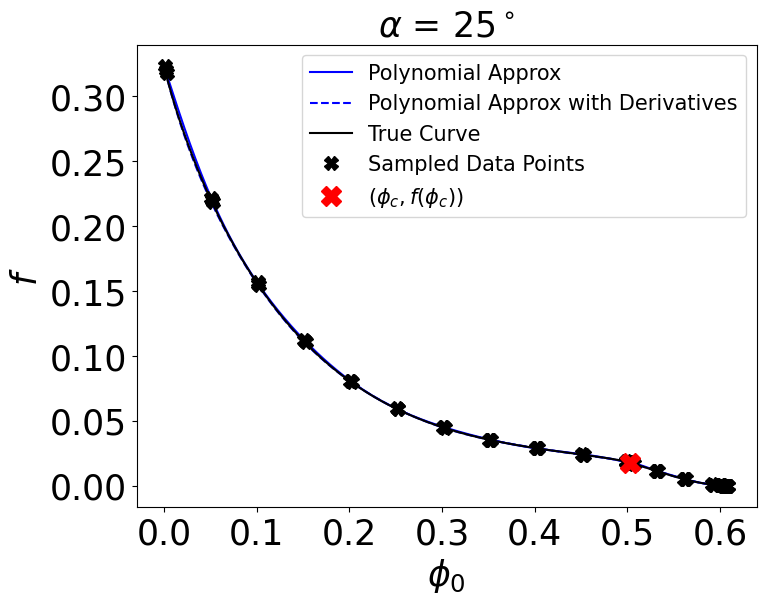

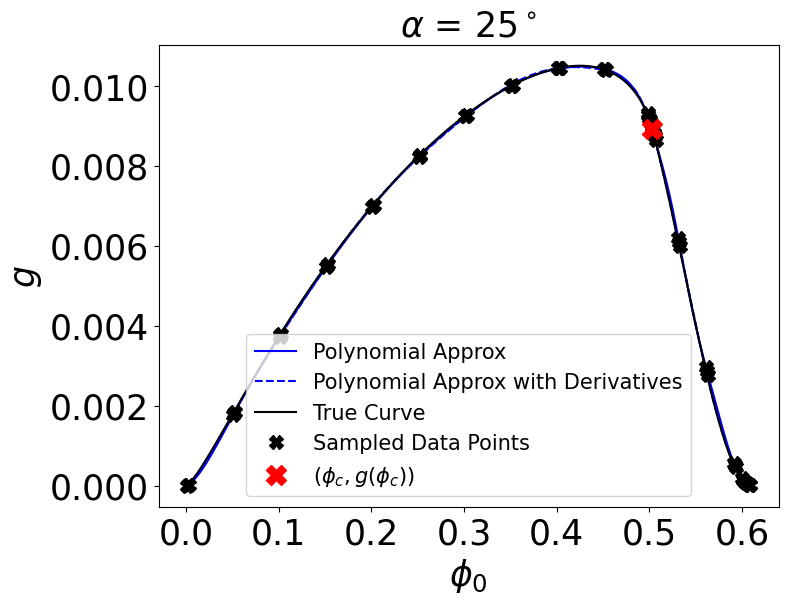

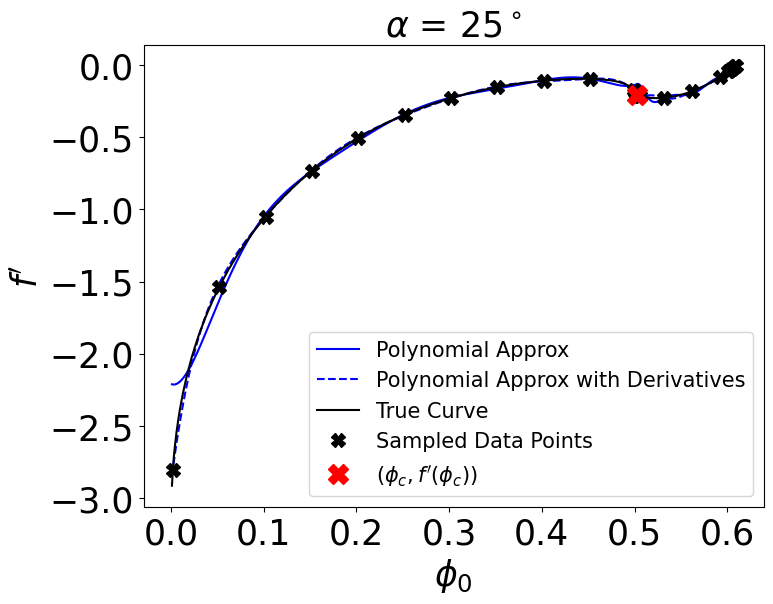

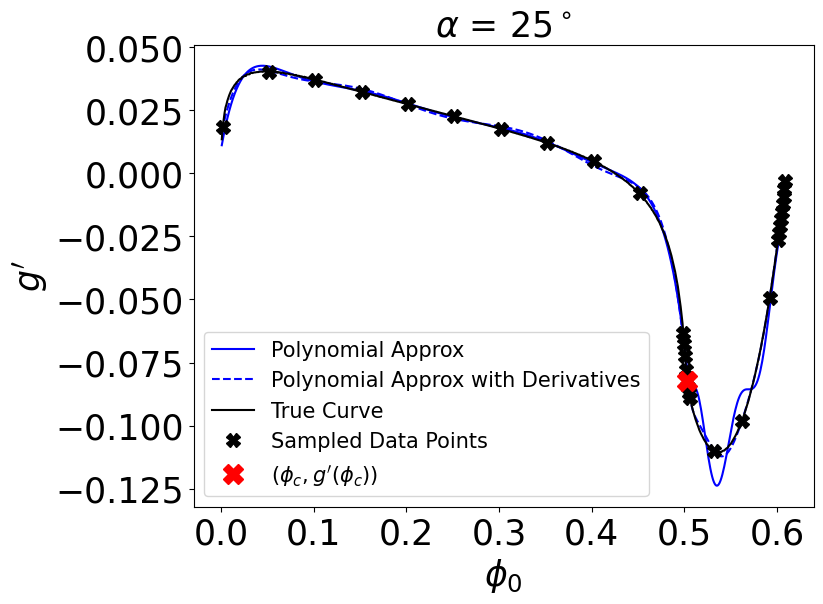

In [7]:
## Polynomial Approximation

phi_0stoplot = np.arange(0,611)[1:-1]*gap
fval = np.array(ffluxfun(phi_0stoplot))
gval = np.array(gfluxfun(phi_0stoplot))
fpval = np.array(fpfluxfun(phi_0stoplot))
gpval = np.array(gpfluxfun(phi_0stoplot))

### Flux f
plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, ffluxfunapprox(np.array(phi_0stoplot), f_coef , deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx")
plt.plot(phi_0stoplot, ffluxfunapprox(np.array(phi_0stoplot), f_coef_d , deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx with Derivatives", linestyle='dashed')
plt.plot(phi_0stoplot, fval, color = 'black', label = "True Curve")
plt.plot(sampledindunq*gap, y_f[:Ndata], marker = 'X', color = 'black', ls='none', ms = 10, label = "Sampled Data Points")
plt.plot(phi_c, fc, marker = 'X', color = (1,0,0), ls='none', ms = 15, label = r"$(\phi_c,f(\phi_c))$")
plt.title( r'$\alpha$' + f' = {alphadeg}$^\circ$',fontsize=25)
plt.xlabel('$\phi_0$',fontsize = 25)
plt.ylabel('$f$',fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="upper right",fontsize = 15)
plt.show()

### Flux g
plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, gfluxfunapprox(np.array(phi_0stoplot), g_coef, deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx")
plt.plot(phi_0stoplot, gfluxfunapprox(np.array(phi_0stoplot), g_coef_d, deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx with Derivatives", linestyle='dashed')
plt.plot(phi_0stoplot, gval, color = 'black', label = "True Curve")
plt.plot(sampledindunq*gap, y_g[:Ndata], marker = 'X', color = 'black', ls='none', ms = 10, label = "Sampled Data Points")
plt.plot(phi_c, gc, marker = 'X', color = (1,0,0), ls='none', ms = 15, label = r"$(\phi_c,g(\phi_c))$")
plt.title( r'$\alpha$' + f' = {alphadeg}$^\circ$',fontsize=25)
plt.xlabel('$\phi_0$', fontsize = 25)
plt.ylabel('$g$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower center",fontsize = 15)
plt.show()


### Flux f'
plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, fpfluxfunapprox(np.array(phi_0stoplot), f_coef, deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx")
plt.plot(phi_0stoplot, fpfluxfunapprox(np.array(phi_0stoplot), f_coef_d, deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx with Derivatives", linestyle='dashed')
plt.plot(phi_0stoplot, fpval, color = 'black', label = "True Curve")
plt.plot(sampledindunq_d*gap, np.array(y_f_p), marker = 'X', color = 'black', ls='none', ms = 10, label = "Sampled Data Points")
plt.plot(phi_c, fcp, marker = 'X', color = (1,0,0), ls='none', ms = 15, label = r"$(\phi_c,f'(\phi_c))$")
plt.title( r'$\alpha$' + f' = {alphadeg}$^\circ$',fontsize=25)
plt.xlabel('$\phi_0$',fontsize = 25)
plt.ylabel('$f\'$',fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower right",fontsize = 15)
plt.show()

### Flux g'
plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, gpfluxfunapprox(np.array(phi_0stoplot), g_coef, deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx")
plt.plot(phi_0stoplot, gpfluxfunapprox(np.array(phi_0stoplot), g_coef_d, deg_settled, deg_ridged), color = (0,0,1), label = "Polynomial Approx with Derivatives", linestyle='dashed')
plt.plot(phi_0stoplot, gpval, color = 'black', label = "True Curve")
plt.plot(sampledindunq_d*gap, np.array(y_g_p), marker = 'X', color = 'black', ls='none', ms = 10, label = "Sampled Data Points")
plt.plot(phi_c, gcp, marker = 'X', color = (1,0,0), ls='none', ms = 15, label = r"$(\phi_c,g'(\phi_c))$")
plt.title( r'$\alpha$' + f' = {alphadeg}$^\circ$',fontsize=25)
plt.xlabel('$\phi_0$', fontsize = 25)
plt.ylabel('$g\'$', fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left",fontsize = 15)
plt.show()



### PDE Solver

First, we will attempt to determine the maximum speed of propagation of waves. This is essential in ensuring that the CFL condition will not be violated. Pre-computing this value allows us to set a uniform grid in both space and time for our PDE simulations (numerical schemes), which cuts down the computational time required to the maximum speed of propagation at each step of the computation.

To do so, recall that the larger of the two eigenvalues of the Jacobian matrix is given by (expression given in equation (A.13) and (A.14) of the paper)
$$ \lambda_2 = \frac{1}{2}(F_u + G_v + \sqrt{(F_u + G_v)^2 - 4(F_u G_v - F_v G_u)})$$
Since $$u = h, \, v = h\phi_0,\,  F(h,h\phi_0) = h^3 f\left(\frac{h\phi_0}{h}\right), \text{ and } G(h,h\phi_0) = h^3 g\left( \frac{h \phi_0}{h}\right),$$
one can show that
$$\begin{aligned}  
F_u &= h^2\left( 3f(\phi_0) - \phi_0f'(\phi_0) \right), \\
F_v &= h^2\left( f'(\phi_0) \right), \\
G_u &= h^2\left( 3g(\phi_0) - \phi_0g'(\phi_0) \right), \\
G_v &= h^2\left( g'(\phi_0) \right), \\
\end{aligned}$$
and hence
$$ \lambda_2(h,\phi_0) = \frac{1}{2}h^2\left(\tilde{\lambda}_2(\phi_0)\right)$$
with
$$\begin{aligned}  
\tilde{\lambda}_2(\phi_0) &= \left( T(h,\phi_0) + \sqrt{T^2(h,\phi_0) - 4 D(h,\phi_0)}\right), \\
T &= 3f(\phi_0) - \phi_0f'(\phi_0) + g'(\phi_0), \\
D &=  (3f(\phi_0) - \phi_0f'(\phi_0)) \times g'(\phi_0) - (3g(\phi_0)-\phi_0g'(\phi_0))\times(f'(\phi_0)).
\end{aligned}$$
(Note that it can also be shown that $\tilde{\lambda}_2(\phi_0) \geq 0$ for all $\phi_0 \in [0,\phi_m]$, consistent with the physical interpretation that information (packed as waves) must travel downstream in the positive $x$ direction. Furthermore, for system of conservation laws, the maximum principle might not hold so it is possible for this assumption to be violated!)

Suppose that we provide a potential estimate for $h$, that is, for Riemann initial data with $$h(0,x) \leq 1,$$ we have $$h(t,x) \leq \sqrt{2}, \text{ a.e}$$
then this would imply that 
$$\lambda_2(h,\phi_0) \leq |\tilde{\lambda}_2(\phi_0)|.$$
By pre-computing that maximum of $\tilde{\lambda}_2(\phi_0)$ over $\phi_0 \in [0,\phi_m = 0.61]$, one can provide an upper bound for $\lambda_2(h,\phi_0)$. By the CFL condition, one has to pick the time step $\Delta t$ and the spatial grid size $\Delta x$ such that
$$\left( \max_{\phi_0}\tilde{\lambda_2}(\phi_0) \right) \Delta t \leq \Delta x. $$

It is customary to check that the estimate for $h$ indeed holds from the plot of the solutions (in particular, $h$) to the PDE.


<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\l'
C:\Users\hktan\AppData\Local\Temp\ipykernel_24800\1597690129.py:18: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(phi_0stoplot, lambda_2val, color = 'black', label = f"$\\tilde\lambda_2$", linewidth=3)
C:\Users\hktan\AppData\Local\Temp\ipykernel_24800\1597690129.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.title( r'$\alpha$' + f' = {alphadeg}$^\circ$',fontsize=25)
C:\Users\hktan\AppData\Local\Temp\ipykernel_24800\1597690129.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_0$',fontsize = 25)
C:\Users\hktan\AppData\Local\Temp\ipykernel_24800\159

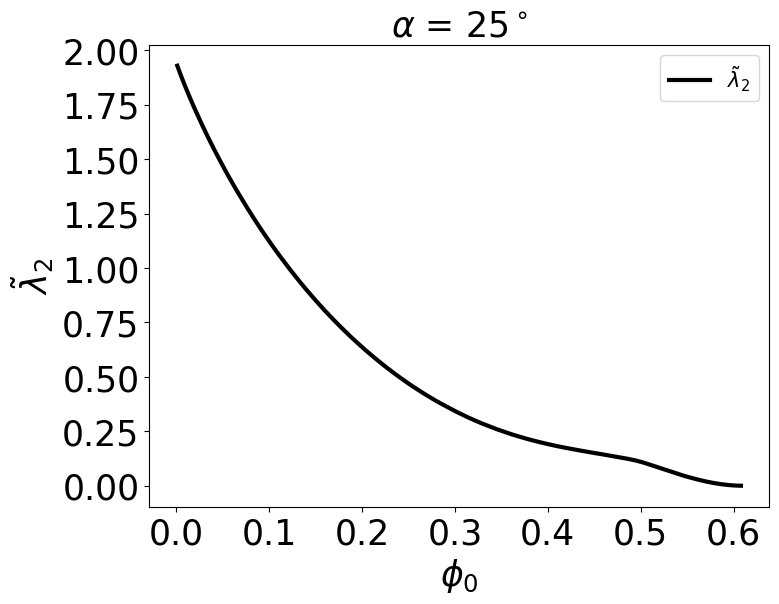

In [17]:
### Determining the maximum speed of propagation for the waves (to be shared among all types of approximations to the flux functions)


phi_0stoplot = np.arange(0,611)[1:-1]*gap
## Recall that these are the interpolated flux functions
fval = np.array(ffluxfun(phi_0stoplot))
gval = np.array(gfluxfun(phi_0stoplot))
fpval = np.array(fpfluxfun(phi_0stoplot))  
gpval = np.array(gpfluxfun(phi_0stoplot))
T = 3*fval - phi_0stoplot*fpval + gpval
D = (3*fval - phi_0stoplot*fpval)*gpval - (3*gval - phi_0stoplot*gpval)*fpval
lambda_2val = T + (T**2 - 4*D)**(1/2)



### Flux f
plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, lambda_2val, color = 'black', label = f"$\\tilde\lambda_2$", linewidth=3)
plt.title( r'$\alpha$' + f' = {alphadeg}$^\circ$',fontsize=25)
plt.xlabel('$\phi_0$',fontsize = 25)
plt.ylabel(f'$\\tilde\lambda_2$',fontsize = 25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="upper right",fontsize = 15)
plt.show()

In [25]:
### PDE Solver (Double Shock Initial Conditions)


### Sptial step size is pre-determined based on the temporal step size (minimum allowed by CFL conditions).
def FDSSolver(tend,xleft,xright,tstep,initu1,initu2,fflux,gflux):
  # The variables here are self-explanatory. We also assume that we start from t = 0.
  # initu1 and initu2 are the initial conditions, which are functions of space that acts on np.arrays
  # Recall that u1 = h, and u2 = h phi_0
  # Additional Remark I: The system exhibits positivity, which means that all waves must travel to the right. To capture the correct dynamics,
  #     I recommend picking xright - xR > 2*tend, where xR is the last "jump discontinuity" from the given initial data. 
  # Additional Remark II: We assume that xleft is chosen such that we have the same constant state for all x < xleft. This implies that the
  #     correct left numerical boundary condition would always be u1(x = xleft) and u2(x = xleft)
  lbd = 2 # Max value of eigenvalue, pre-computed for alpha = 30 degrees; have to change this if angle is changed (see the previous block)
  xstep = lbd*tstep # Maximize coverage in the x-direction as allowed by CFL condition
  Nx = round((xright - xleft)/xstep) 
  Nt = round(tend/tstep) + 1 
  x = np.linspace(xleft,xright,Nx)
  t = np.linspace(0,tend,Nt)
  u1prev = initu1(x)
  u2prev = initu2(x)
  u1next = np.ones(Nx) ## This can be anything that is non-zero; I'm just trying to initialize a non-zero np.array
  u2next = np.ones(Nx)
  u1next[0], u2next[0] = u1prev[0], u2prev[0] ## See Additional Remark II
  for tt in range(1,Nt):
      # u1right refers to the values of u with index shifted to the right by 1; a similar etymology holds for the other three terms
      u1right, u1left, u2right, u2left = u1prev[1:], u1prev[:-1], u2prev[1:], u2prev[:-1]
      u1next[1:] = u1right - 1/lbd*(u1right**3*(fflux(u2right/u1right))-u1left**3*(fflux(u2left/u1left)))
      u2next[1:] = u2right - 1/lbd*(u1right**3*(gflux(u2right/u1right))-u1left**3*(gflux(u2left/u1left)))
      u1prev, u2prev = u1next, u2next
  return x, u1next, u2next

## First argument is h, Second argument is hphi
hleft = 1
phi_0left = 0.485
hright = 0.2
phi_0right = 0.485

#hleft = 1
#phi_0left = 0.485
#hright = 0.2
#phi_0right = 0.485

def h_init(x):
   ## Input: x is a np.array
   ## hleft and hright are "global" - though this could be implemented as the arguments of the function for clarity
   return hleft*np.heaviside(-x, 0.5) + hright*np.heaviside(x,0.5)

def hphi_init(x):
   ## Input: x is a np.array
   return hleft*phi_0left*np.heaviside(-x,0.5) + hright*phi_0right*np.heaviside(x,0.5)


#### Comparing Types of Approximation - Computational Time and Quality of PDE solutions


 Time Elapsed:  27.937000000005355  seconds


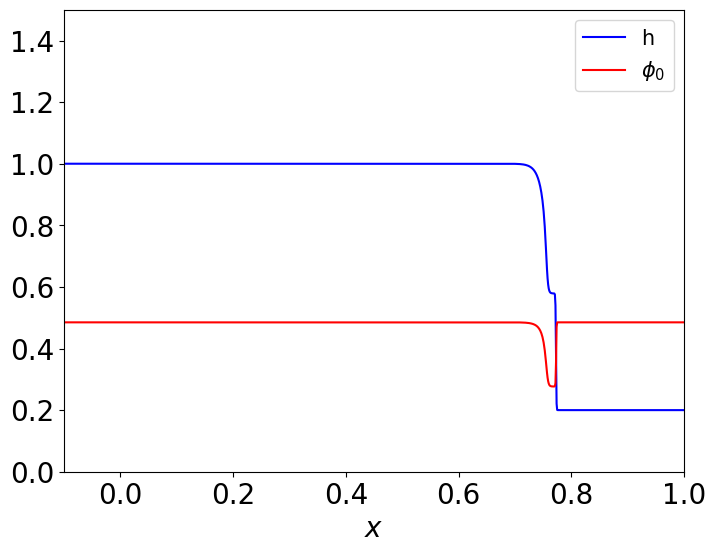

In [28]:

start_time = time.monotonic()

xfinal, u1final, u2final = FDSSolver(30,-0.1,1,0.0005, h_init, hphi_init, ffluxfun, gfluxfun)

end_time = time.monotonic()
print("\n Time Elapsed: ", end_time - start_time, " seconds" )

plt.figure(figsize = (8,6))
plt.plot(xfinal, u1final, color = (0,0,1), label = "h")
plt.plot(xfinal, np.array(u2final)/np.array(u1final), color = (1,0,0), label = "$\\phi_0$")
plt.xlabel(r'$x$',fontsize=20)
plt.xlim([-0.1,1]) # You should only view the plot in the same (xleft,xright)
plt.ylim([0,1.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper right", fontsize=15)
plt.show()


 Time Elapsed:  161.90599999998813  seconds


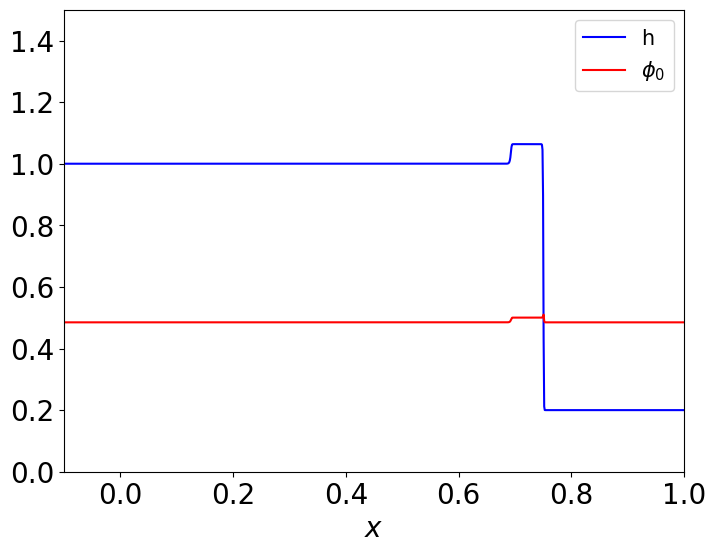

In [29]:
def ffluxfunapprox_forpde(phinot):
    return ffluxfunapprox(phinot, f_coef, deg_settled, deg_ridged)

def gfluxfunapprox_forpde(phinot):
    return gfluxfunapprox(phinot, g_coef, deg_settled, deg_ridged)

start_time = time.monotonic()

xfinal_approx, u1final_approx, u2final_approx = FDSSolver(30,-0.1,1,0.0005, h_init, hphi_init, ffluxfunapprox_forpde, gfluxfunapprox_forpde)

end_time = time.monotonic()
print("\n Time Elapsed: ", end_time - start_time, " seconds" )

plt.figure(figsize = (8,6))
plt.plot(xfinal_approx, u1final_approx, color = (0,0,1), label = "h")
plt.plot(xfinal_approx, np.array(u2final_approx)/np.array(u1final_approx), color = (1,0,0), label = "$\\phi_0$")
plt.xlabel(r'$x$',fontsize=20)
plt.xlim([-0.1,1]) # You should only view the plot in the same (xleft,xright)
plt.ylim([0,1.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper right", fontsize=15)
plt.show()


 Time Elapsed:  2065.344000000012  seconds


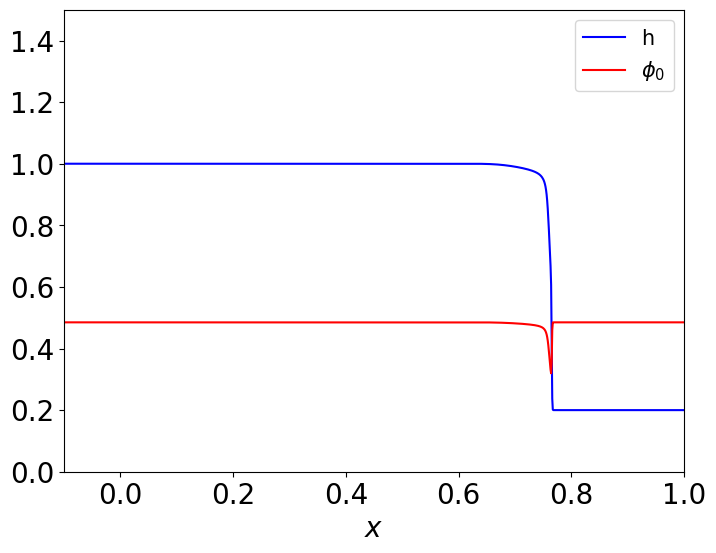

In [30]:
def ffluxfunapprox_p_forpde(phinot):
    return ffluxfunapprox(phinot,f_coef_d, deg_settled, deg_ridged)

def gfluxfunapprox_p_forpde(phinot):
    return gfluxfunapprox(phinot, g_coef_d, deg_settled, deg_ridged)

start_time = time.monotonic()

xfinal_approx_p, u1final_approx_p, u2final_approx_p = FDSSolver(30,-0.1,12,0.0005, h_init, hphi_init, ffluxfunapprox_p_forpde, gfluxfunapprox_p_forpde)

end_time = time.monotonic()
print("\n Time Elapsed: ", end_time - start_time, " seconds" )

plt.figure(figsize = (8,6))
plt.plot(xfinal_approx_p, u1final_approx_p, color = (0,0,1), label = "h")
plt.plot(xfinal_approx_p, np.array(u2final_approx_p)/np.array(u1final_approx_p), color = (1,0,0), label = "$\\phi_0$")
plt.xlabel(r'$x$',fontsize=20)
plt.xlim([-0.1,1]) # You should only view the plot in the same (xleft,xright)
plt.ylim([0,1.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper right", fontsize=15)
plt.show()

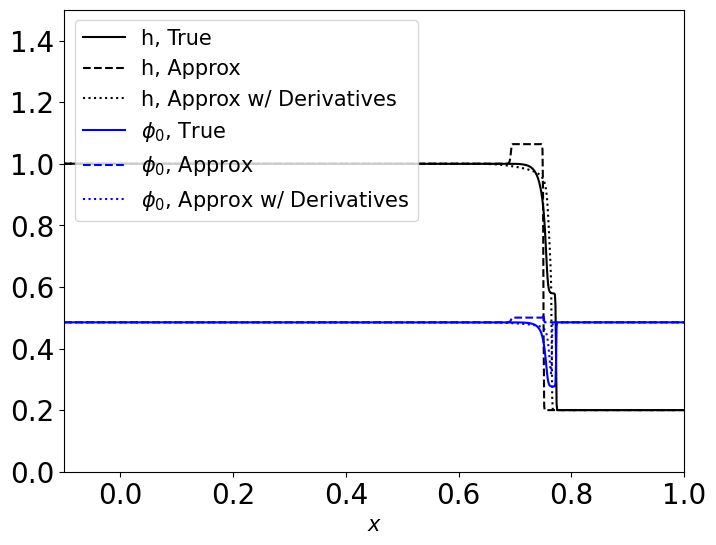

In [31]:
plt.figure(figsize = (8,6))
plt.plot(xfinal, u1final, color = (0,0,0), label = "h, True")
plt.plot(xfinal_approx, u1final_approx, color = (0,0,0), label = "h, Approx", linestyle='dashed')
plt.plot(xfinal_approx_p, u1final_approx_p, color = (0,0,0), label = "h, Approx w/ Derivatives", linestyle='dotted')
plt.plot(xfinal, np.array(u2final)/np.array(u1final), color = (0,0,1), label = "$\\phi_0$, True")
plt.plot(xfinal_approx, np.array(u2final_approx)/np.array(u1final_approx), color = (0,0,1), label = "$\\phi_0$, Approx", linestyle='dashed')
plt.plot(xfinal_approx_p, np.array(u2final_approx_p)/np.array(u1final_approx_p), color = (0,0,1), label = "$\\phi_0$, Approx w/ Derivatives", linestyle='dotted')
plt.xlabel(r'$x$', fontsize = 15)
#plt.xlim([0.6,0.9]) # You should only view the plot in the same (xleft,xright)
plt.xlim([-0.1,1.0])
plt.ylim([0,1.5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left", fontsize=15)
plt.show()

### Hugoniot Loci and Rarefaction Curves

(1) For 

$$(h,h\phi_0)(0,x) = \begin{cases} (1.0,0.4) &\text{ for } x < 0 \\ (0.2,0.4) &\text{ for } x > 0 \end{cases}$$

using polynomial approximation fitted without derivative data

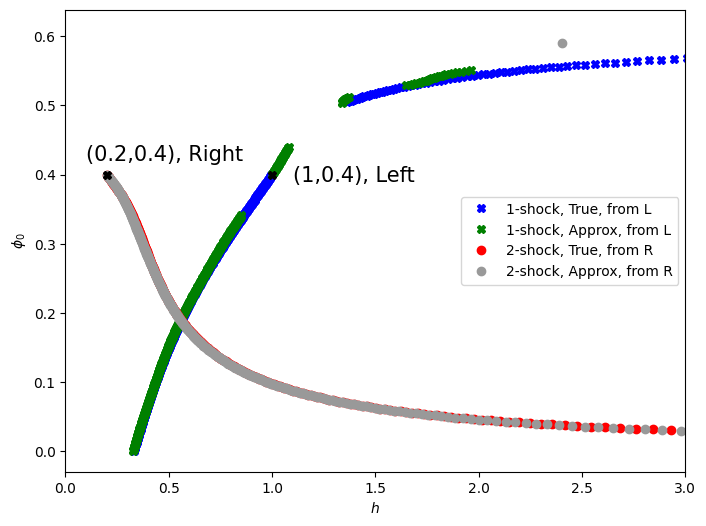

In [8]:
hleft = 1
phi_0left = 0.4

def eigenvalstate(phi_0, h, ffun, gfun, fpfun, gpfun):
  ## Note: phi_0 - scalar, the flux functions take in scalar values
  fval = np.array(ffun(phi_0))
  gval = np.array(gfun(phi_0))
  fpval = np.array(fpfun(phi_0))  
  gpval = np.array(gpfun(phi_0))
  T = 3*fval - phi_0*fpval + gpval
  D = (3*fval - phi_0*fpval)*gpval - (3*gval - phi_0*gpval)*fpval
  disc = max(0,T**2 - 4*D)  ## For numerical positivity; it is possible for T**2 - 4*D to be slightly negative.
  lambda_1val = 1/2*h**2*(T - disc**(1/2))
  lambda_2val = 1/2*h**2*(T + disc**(1/2))
  return lambda_1val, lambda_2val

def ffluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return ffluxfunapprox(phi_0,f_coef, deg_settled, deg_ridged)[0]


def gfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gfluxfunapprox(phi_0,g_coef, deg_settled, deg_ridged)[0]


def fpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return fpfluxfunapprox(phi_0,f_coef, deg_settled, deg_ridged)[0]


def gpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gpfluxfunapprox(phi_0,g_coef, deg_settled, deg_ridged)[0]

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  #[2:-2]

phi_0_hugo1 = []
phi_0_hugo2 = []
h1 = [] # 1-shock connections
h2 = [] # 2-shock connections

phi_0_hugo1_approx = []
phi_0_hugo2_approx = []
h1_approx = [] # 1-shock connections
h2_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hleft*(gfluxfun(phi_0test) - phi_0left*ffluxfun(phi_0test))
  coef1 = hleft**3*(gfluxfun(phi_0left) - phi_0test*ffluxfun(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfun(phi_0left) - gfluxfun(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfun(phi_0left) - hguess**3*ffluxfun(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test, hguess, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1.append(hguess)
        phi_0_hugo1.append(phi_0test)
      if indicator == 2:
        h2.append(hguess)
        phi_0_hugo2.append(phi_0test)



for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hleft*(gfluxfunapprox_forhugo(phi_0test) - phi_0left*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hleft**3*(gfluxfunapprox_forhugo(phi_0left) - phi_0test*ffluxfunapprox_forhugo(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfunapprox_forhugo(phi_0left) - gfluxfunapprox_forhugo(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfunapprox_forhugo(phi_0left) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1_approx.append(hguess)
        phi_0_hugo1_approx.append(phi_0test)
      if indicator == 2:
        h2_approx.append(hguess)
        phi_0_hugo2_approx.append(phi_0test)

hright = 0.2
phi_0right = 0.4

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  

phi_0_hugo3 = []
phi_0_hugo4 = []
h3 = [] # 1-shock connections
h4 = [] # 2-shock connections

phi_0_hugo3_approx = []
phi_0_hugo4_approx = []
h3_approx = [] # 1-shock connections
h4_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hright*(gfluxfun(phi_0test) - phi_0right*ffluxfun(phi_0test))
  coef1 = hright**3*(gfluxfun(phi_0right) - phi_0test*ffluxfun(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfun(phi_0right) - gfluxfun(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfun(phi_0right) - hguess**3*ffluxfun(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3.append(hguess)
        phi_0_hugo3.append(phi_0test)
      if indicator == 2:
        h4.append(hguess)
        phi_0_hugo4.append(phi_0test)


for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hright*(gfluxfunapprox_forhugo(phi_0test) - phi_0right*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hright**3*(gfluxfunapprox_forhugo(phi_0right) - phi_0test*ffluxfunapprox_forhugo(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfunapprox_forhugo(phi_0right) - gfluxfunapprox_forhugo(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfunapprox_forhugo(phi_0right) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3_approx.append(hguess)
        phi_0_hugo3_approx.append(phi_0test)
      if indicator == 2:
        h4_approx.append(hguess)
        phi_0_hugo4_approx.append(phi_0test)

plt.figure(figsize = (8,6))
plt.plot(h1,phi_0_hugo1,color = (0,0,1), label = "1-shock, True, from L", marker = 'X', ls='none', ms = 6)
plt.plot(h1_approx,phi_0_hugo1_approx,color = (0,0.5,0), label = "1-shock, Approx, from L", marker = "X", ls='none', ms = 6)
plt.plot(h4,phi_0_hugo4,color = (1,0,0), label = "2-shock, True, from R", marker = 'o', ls='none', ms = 6)
plt.plot(h4_approx,phi_0_hugo4_approx,color = (0.6,0.6,0.6), label = "2-shock, Approx, from R", marker = "o", ls='none', ms = 6)
plt.plot([hleft],[phi_0left], marker = 'X', color = 'black', ls='none')
plt.text(hleft+0.1,phi_0left - 0.01,"(" + str(hleft)  + "," + str(phi_0left) + "), Left",fontsize=15)
plt.plot([hright],[phi_0right], marker = 'X', color = 'black', ls='none')
plt.text(hright-0.1,phi_0right + 0.02,"(" + str(hright)  + "," + str(phi_0right) + "), Right",fontsize=15)
plt.legend(loc="right")
plt.xlim([0,3])
#plt.ylim([0.4,0.6])
plt.xlabel(r'$h$')
plt.ylabel(r'$\phi_0$')
plt.show()

With derivative data

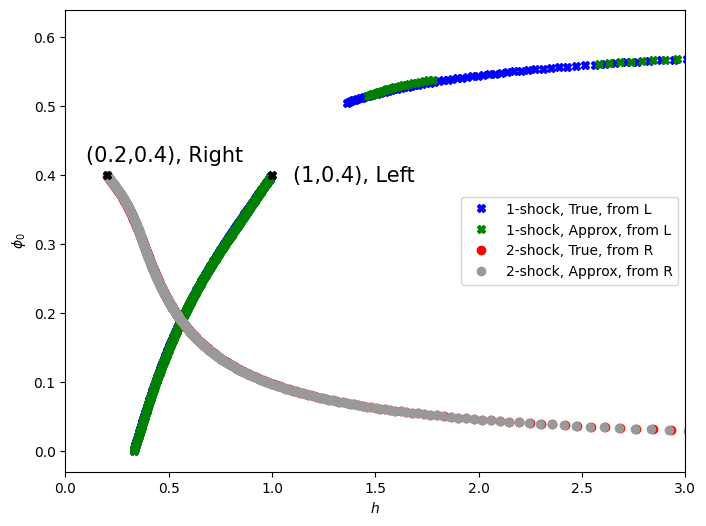

In [9]:
hleft = 1
phi_0left = 0.4

def eigenvalstate(phi_0, h, ffun, gfun, fpfun, gpfun):
  ## Note: phi_0 - scalar, the flux functions take in scalar values
  fval = np.array(ffun(phi_0))
  gval = np.array(gfun(phi_0))
  fpval = np.array(fpfun(phi_0))  
  gpval = np.array(gpfun(phi_0))
  T = 3*fval - phi_0*fpval + gpval
  D = (3*fval - phi_0*fpval)*gpval - (3*gval - phi_0*gpval)*fpval
  disc = max(0,T**2 - 4*D)  ## For numerical positivity; it is possible for T**2 - 4*D to be slightly negative.
  lambda_1val = 1/2*h**2*(T - disc**(1/2))
  lambda_2val = 1/2*h**2*(T + disc**(1/2))
  return lambda_1val, lambda_2val

def ffluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return ffluxfunapprox(phi_0,f_coef_d, deg_settled, deg_ridged)[0]


def gfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gfluxfunapprox(phi_0,g_coef_d, deg_settled, deg_ridged)[0]


def fpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return fpfluxfunapprox(phi_0,f_coef_d, deg_settled, deg_ridged)[0]


def gpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gpfluxfunapprox(phi_0,g_coef_d, deg_settled, deg_ridged)[0]

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  #[2:-2]

phi_0_hugo1 = []
phi_0_hugo2 = []
h1 = [] # 1-shock connections
h2 = [] # 2-shock connections

phi_0_hugo1_approx = []
phi_0_hugo2_approx = []
h1_approx = [] # 1-shock connections
h2_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hleft*(gfluxfun(phi_0test) - phi_0left*ffluxfun(phi_0test))
  coef1 = hleft**3*(gfluxfun(phi_0left) - phi_0test*ffluxfun(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfun(phi_0left) - gfluxfun(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfun(phi_0left) - hguess**3*ffluxfun(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test, hguess, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1.append(hguess)
        phi_0_hugo1.append(phi_0test)
      if indicator == 2:
        h2.append(hguess)
        phi_0_hugo2.append(phi_0test)



for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hleft*(gfluxfunapprox_forhugo(phi_0test) - phi_0left*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hleft**3*(gfluxfunapprox_forhugo(phi_0left) - phi_0test*ffluxfunapprox_forhugo(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfunapprox_forhugo(phi_0left) - gfluxfunapprox_forhugo(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfunapprox_forhugo(phi_0left) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1_approx.append(hguess)
        phi_0_hugo1_approx.append(phi_0test)
      if indicator == 2:
        h2_approx.append(hguess)
        phi_0_hugo2_approx.append(phi_0test)

hright = 0.2
phi_0right = 0.4

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  

phi_0_hugo3 = []
phi_0_hugo4 = []
h3 = [] # 1-shock connections
h4 = [] # 2-shock connections

phi_0_hugo3_approx = []
phi_0_hugo4_approx = []
h3_approx = [] # 1-shock connections
h4_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hright*(gfluxfun(phi_0test) - phi_0right*ffluxfun(phi_0test))
  coef1 = hright**3*(gfluxfun(phi_0right) - phi_0test*ffluxfun(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfun(phi_0right) - gfluxfun(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfun(phi_0right) - hguess**3*ffluxfun(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3.append(hguess)
        phi_0_hugo3.append(phi_0test)
      if indicator == 2:
        h4.append(hguess)
        phi_0_hugo4.append(phi_0test)


for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hright*(gfluxfunapprox_forhugo(phi_0test) - phi_0right*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hright**3*(gfluxfunapprox_forhugo(phi_0right) - phi_0test*ffluxfunapprox_forhugo(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfunapprox_forhugo(phi_0right) - gfluxfunapprox_forhugo(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfunapprox_forhugo(phi_0right) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3_approx.append(hguess)
        phi_0_hugo3_approx.append(phi_0test)
      if indicator == 2:
        h4_approx.append(hguess)
        phi_0_hugo4_approx.append(phi_0test)

plt.figure(figsize = (8,6))
plt.plot(h1,phi_0_hugo1,color = (0,0,1), label = "1-shock, True, from L", marker = 'X', ls='none', ms = 6)
plt.plot(h1_approx,phi_0_hugo1_approx,color = (0,0.5,0), label = "1-shock, Approx, from L", marker = "X", ls='none', ms = 6)
plt.plot(h4,phi_0_hugo4,color = (1,0,0), label = "2-shock, True, from R", marker = 'o', ls='none', ms = 6)
plt.plot(h4_approx,phi_0_hugo4_approx,color = (0.6,0.6,0.6), label = "2-shock, Approx, from R", marker = "o", ls='none', ms = 6)
plt.plot([hleft],[phi_0left], marker = 'X', color = 'black', ls='none')
plt.text(hleft+0.1,phi_0left - 0.01,"(" + str(hleft)  + "," + str(phi_0left) + "), Left",fontsize=15)
plt.plot([hright],[phi_0right], marker = 'X', color = 'black', ls='none')
plt.text(hright-0.1,phi_0right + 0.02,"(" + str(hright)  + "," + str(phi_0right) + "), Right",fontsize=15)
plt.legend(loc="right")
plt.xlim([0,3])
#plt.ylim([0.4,0.6])
plt.xlabel(r'$h$')
plt.ylabel(r'$\phi_0$')
plt.show()

(2) For 

$$(h,h\phi_0)(0,x) = \begin{cases} (1.0,0.485) &\text{ for } x < 0 \\ (0.2,0.485) &\text{ for } x > 0 \end{cases}$$

using polynomial approximation fitted without derivative data

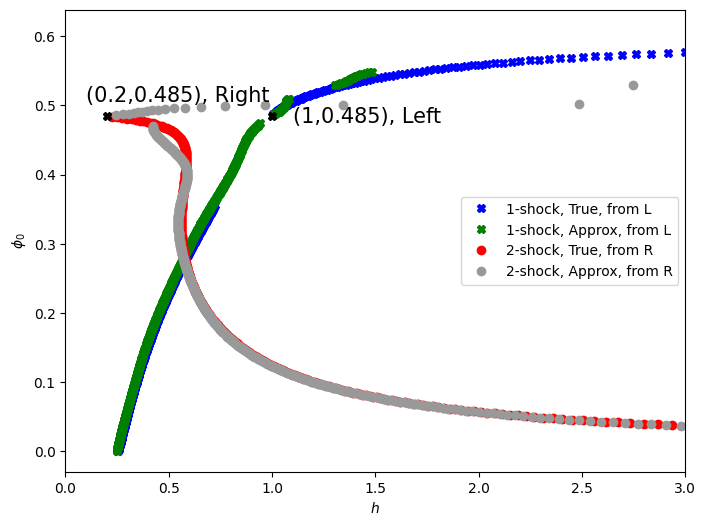

In [10]:
hleft = 1
phi_0left = 0.485

def eigenvalstate(phi_0, h, ffun, gfun, fpfun, gpfun):
  ## Note: phi_0 - scalar, the flux functions take in scalar values
  fval = np.array(ffun(phi_0))
  gval = np.array(gfun(phi_0))
  fpval = np.array(fpfun(phi_0))  
  gpval = np.array(gpfun(phi_0))
  T = 3*fval - phi_0*fpval + gpval
  D = (3*fval - phi_0*fpval)*gpval - (3*gval - phi_0*gpval)*fpval
  disc = max(0,T**2 - 4*D)  ## For numerical positivity; it is possible for T**2 - 4*D to be slightly negative.
  lambda_1val = 1/2*h**2*(T - disc**(1/2))
  lambda_2val = 1/2*h**2*(T + disc**(1/2))
  return lambda_1val, lambda_2val

def ffluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return ffluxfunapprox(phi_0,f_coef, deg_settled, deg_ridged)[0]


def gfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gfluxfunapprox(phi_0,g_coef, deg_settled, deg_ridged)[0]


def fpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return fpfluxfunapprox(phi_0,f_coef, deg_settled, deg_ridged)[0]


def gpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gpfluxfunapprox(phi_0,g_coef, deg_settled, deg_ridged)[0]

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  #[2:-2]

phi_0_hugo1 = []
phi_0_hugo2 = []
h1 = [] # 1-shock connections
h2 = [] # 2-shock connections

phi_0_hugo1_approx = []
phi_0_hugo2_approx = []
h1_approx = [] # 1-shock connections
h2_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hleft*(gfluxfun(phi_0test) - phi_0left*ffluxfun(phi_0test))
  coef1 = hleft**3*(gfluxfun(phi_0left) - phi_0test*ffluxfun(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfun(phi_0left) - gfluxfun(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfun(phi_0left) - hguess**3*ffluxfun(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test, hguess, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1.append(hguess)
        phi_0_hugo1.append(phi_0test)
      if indicator == 2:
        h2.append(hguess)
        phi_0_hugo2.append(phi_0test)



for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hleft*(gfluxfunapprox_forhugo(phi_0test) - phi_0left*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hleft**3*(gfluxfunapprox_forhugo(phi_0left) - phi_0test*ffluxfunapprox_forhugo(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfunapprox_forhugo(phi_0left) - gfluxfunapprox_forhugo(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfunapprox_forhugo(phi_0left) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1_approx.append(hguess)
        phi_0_hugo1_approx.append(phi_0test)
      if indicator == 2:
        h2_approx.append(hguess)
        phi_0_hugo2_approx.append(phi_0test)

hright = 0.2
phi_0right = 0.485

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  

phi_0_hugo3 = []
phi_0_hugo4 = []
h3 = [] # 1-shock connections
h4 = [] # 2-shock connections

phi_0_hugo3_approx = []
phi_0_hugo4_approx = []
h3_approx = [] # 1-shock connections
h4_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hright*(gfluxfun(phi_0test) - phi_0right*ffluxfun(phi_0test))
  coef1 = hright**3*(gfluxfun(phi_0right) - phi_0test*ffluxfun(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfun(phi_0right) - gfluxfun(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfun(phi_0right) - hguess**3*ffluxfun(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3.append(hguess)
        phi_0_hugo3.append(phi_0test)
      if indicator == 2:
        h4.append(hguess)
        phi_0_hugo4.append(phi_0test)


for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hright*(gfluxfunapprox_forhugo(phi_0test) - phi_0right*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hright**3*(gfluxfunapprox_forhugo(phi_0right) - phi_0test*ffluxfunapprox_forhugo(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfunapprox_forhugo(phi_0right) - gfluxfunapprox_forhugo(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfunapprox_forhugo(phi_0right) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3_approx.append(hguess)
        phi_0_hugo3_approx.append(phi_0test)
      if indicator == 2:
        h4_approx.append(hguess)
        phi_0_hugo4_approx.append(phi_0test)

plt.figure(figsize = (8,6))
plt.plot(h1,phi_0_hugo1,color = (0,0,1), label = "1-shock, True, from L", marker = 'X', ls='none', ms = 6)
plt.plot(h1_approx,phi_0_hugo1_approx,color = (0,0.5,0), label = "1-shock, Approx, from L", marker = "X", ls='none', ms = 6)
plt.plot(h4,phi_0_hugo4,color = (1,0,0), label = "2-shock, True, from R", marker = 'o', ls='none', ms = 6)
plt.plot(h4_approx,phi_0_hugo4_approx,color = (0.6,0.6,0.6), label = "2-shock, Approx, from R", marker = "o", ls='none', ms = 6)
plt.plot([hleft],[phi_0left], marker = 'X', color = 'black', ls='none')
plt.text(hleft+0.1,phi_0left - 0.01,"(" + str(hleft)  + "," + str(phi_0left) + "), Left",fontsize=15)
plt.plot([hright],[phi_0right], marker = 'X', color = 'black', ls='none')
plt.text(hright-0.1,phi_0right + 0.02,"(" + str(hright)  + "," + str(phi_0right) + "), Right",fontsize=15)
plt.legend(loc="right")
plt.xlim([0,3])
#plt.ylim([0.4,0.6])
plt.xlabel(r'$h$')
plt.ylabel(r'$\phi_0$')
plt.show()

With derivative data

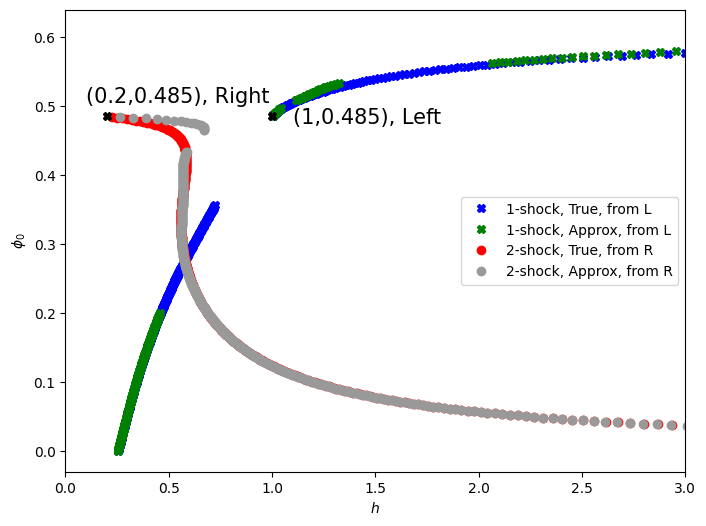

In [11]:
hleft = 1
phi_0left = 0.485

def eigenvalstate(phi_0, h, ffun, gfun, fpfun, gpfun):
  ## Note: phi_0 - scalar, the flux functions take in scalar values
  fval = np.array(ffun(phi_0))
  gval = np.array(gfun(phi_0))
  fpval = np.array(fpfun(phi_0))  
  gpval = np.array(gpfun(phi_0))
  T = 3*fval - phi_0*fpval + gpval
  D = (3*fval - phi_0*fpval)*gpval - (3*gval - phi_0*gpval)*fpval
  disc = max(0,T**2 - 4*D)  ## For numerical positivity; it is possible for T**2 - 4*D to be slightly negative.
  lambda_1val = 1/2*h**2*(T - disc**(1/2))
  lambda_2val = 1/2*h**2*(T + disc**(1/2))
  return lambda_1val, lambda_2val

def ffluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return ffluxfunapprox(phi_0,f_coef_d, deg_settled, deg_ridged)[0]


def gfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gfluxfunapprox(phi_0,g_coef_d, deg_settled, deg_ridged)[0]


def fpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return fpfluxfunapprox(phi_0,f_coef_d, deg_settled, deg_ridged)[0]


def gpfluxfunapprox_forhugo(phi_0):
    ## Input phi_0 is a scalar, but the approx flux functions are vectorized, and thus only takes in 
    ##   phi_0 as a np.array.
    phi_0 = np.array([phi_0])
    return gpfluxfunapprox(phi_0,g_coef_d, deg_settled, deg_ridged)[0]

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  #[2:-2]

phi_0_hugo1 = []
phi_0_hugo2 = []
h1 = [] # 1-shock connections
h2 = [] # 2-shock connections

phi_0_hugo1_approx = []
phi_0_hugo2_approx = []
h1_approx = [] # 1-shock connections
h2_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hleft*(gfluxfun(phi_0test) - phi_0left*ffluxfun(phi_0test))
  coef1 = hleft**3*(gfluxfun(phi_0left) - phi_0test*ffluxfun(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfun(phi_0left) - gfluxfun(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfun(phi_0left) - hguess**3*ffluxfun(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test, hguess, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1.append(hguess)
        phi_0_hugo1.append(phi_0test)
      if indicator == 2:
        h2.append(hguess)
        phi_0_hugo2.append(phi_0test)



for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hleft*(gfluxfunapprox_forhugo(phi_0test) - phi_0left*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hleft**3*(gfluxfunapprox_forhugo(phi_0left) - phi_0test*ffluxfunapprox_forhugo(phi_0left))
  coef0 = hleft**4*(phi_0left*ffluxfunapprox_forhugo(phi_0left) - gfluxfunapprox_forhugo(phi_0left))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hleft**3*ffluxfunapprox_forhugo(phi_0left) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hleft-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0left, hleft, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_given[0] > shockspeed:
        if eigenval_test[0] < shockspeed: 
          if eigenval_test[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_given[1] > shockspeed:
        if eigenval_test[1] < shockspeed:
          if eigenval_given[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h1_approx.append(hguess)
        phi_0_hugo1_approx.append(phi_0test)
      if indicator == 2:
        h2_approx.append(hguess)
        phi_0_hugo2_approx.append(phi_0test)

hright = 0.2
phi_0right = 0.485

phi_0sto = np.arange(0,611)*0.001
phi_0_hugo = phi_0sto[1:-1]  

phi_0_hugo3 = []
phi_0_hugo4 = []
h3 = [] # 1-shock connections
h4 = [] # 2-shock connections

phi_0_hugo3_approx = []
phi_0_hugo4_approx = []
h3_approx = [] # 1-shock connections
h4_approx = [] # 2-shock connections

for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfun(phi_0test) - gfluxfun(phi_0test)
  coef3 = hright*(gfluxfun(phi_0test) - phi_0right*ffluxfun(phi_0test))
  coef1 = hright**3*(gfluxfun(phi_0right) - phi_0test*ffluxfun(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfun(phi_0right) - gfluxfun(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfun(phi_0right) - hguess**3*ffluxfun(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfun, gfluxfun, fpfluxfun, gpfluxfun)
      # Check if it is a 1-shock connection
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3.append(hguess)
        phi_0_hugo3.append(phi_0test)
      if indicator == 2:
        h4.append(hguess)
        phi_0_hugo4.append(phi_0test)


for phi_0test in phi_0_hugo:
  coef4 = phi_0test*ffluxfunapprox_forhugo(phi_0test) - gfluxfunapprox_forhugo(phi_0test)
  coef3 = hright*(gfluxfunapprox_forhugo(phi_0test) - phi_0right*ffluxfunapprox_forhugo(phi_0test))
  coef1 = hright**3*(gfluxfunapprox_forhugo(phi_0right) - phi_0test*ffluxfunapprox_forhugo(phi_0right))
  coef0 = hright**4*(phi_0right*ffluxfunapprox_forhugo(phi_0right) - gfluxfunapprox_forhugo(phi_0right))
  hguesses = np.roots([coef4,coef3,0,coef1,coef0])
  for hguess in hguesses:
    if hguess > 0 and abs(hguess.imag) < 1e-8:
      hguess = hguess.real
      shockspeed = (hright**3*ffluxfunapprox_forhugo(phi_0right) - hguess**3*ffluxfunapprox_forhugo(phi_0test))/(hright-hguess)
      indicator = 0
      eigenval_given = eigenvalstate(phi_0right, hright, ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      eigenval_test = eigenvalstate(phi_0test,hguess,ffluxfunapprox_forhugo, gfluxfunapprox_forhugo, fpfluxfunapprox_forhugo, gpfluxfunapprox_forhugo)
      if eigenval_test[0] > shockspeed:
        if eigenval_given[0] < shockspeed:
          if eigenval_given[1] > shockspeed:
            indicator = 1
      # Check if it is a 2-shock connection
      if eigenval_test[1] > shockspeed:
        if eigenval_given[1] < shockspeed:
          if eigenval_test[0] < shockspeed:
            indicator = 2
      if indicator == 1:
        h3_approx.append(hguess)
        phi_0_hugo3_approx.append(phi_0test)
      if indicator == 2:
        h4_approx.append(hguess)
        phi_0_hugo4_approx.append(phi_0test)

plt.figure(figsize = (8,6))
plt.plot(h1,phi_0_hugo1,color = (0,0,1), label = "1-shock, True, from L", marker = 'X', ls='none', ms = 6)
plt.plot(h1_approx,phi_0_hugo1_approx,color = (0,0.5,0), label = "1-shock, Approx, from L", marker = "X", ls='none', ms = 6)
plt.plot(h4,phi_0_hugo4,color = (1,0,0), label = "2-shock, True, from R", marker = 'o', ls='none', ms = 6)
plt.plot(h4_approx,phi_0_hugo4_approx,color = (0.6,0.6,0.6), label = "2-shock, Approx, from R", marker = "o", ls='none', ms = 6)
plt.plot([hleft],[phi_0left], marker = 'X', color = 'black', ls='none')
plt.text(hleft+0.1,phi_0left - 0.01,"(" + str(hleft)  + "," + str(phi_0left) + "), Left",fontsize=15)
plt.plot([hright],[phi_0right], marker = 'X', color = 'black', ls='none')
plt.text(hright-0.1,phi_0right + 0.02,"(" + str(hright)  + "," + str(phi_0right) + "), Right",fontsize=15)
plt.legend(loc="right")
plt.xlim([0,3])
#plt.ylim([0.4,0.6])
plt.xlabel(r'$h$')
plt.ylabel(r'$\phi_0$')
plt.show()

## Plot of Eigenvalues

$$\lambda_k = \frac{1}{2}h^2\left( \text{tr} + (2k-3) \sqrt{\text{tr}^2 - \text{det}} \right)(\phi_0)$$


$$\tilde{\lambda_k}(\phi_0) = \frac{2\lambda_k}{h^2} = \left( \text{tr} + (2k-3) \sqrt{\text{tr}^2 - \text{det}} \right)(\phi_0)$$


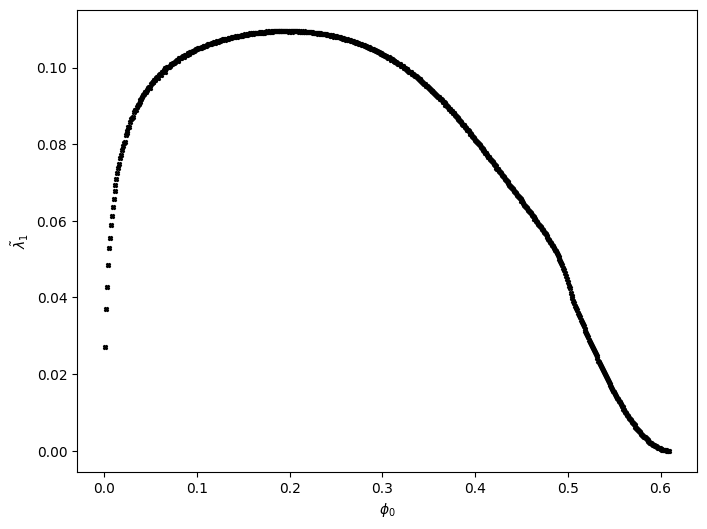

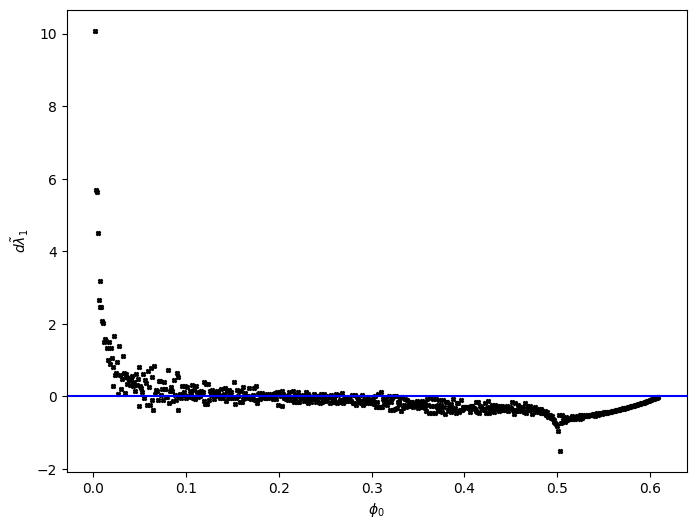

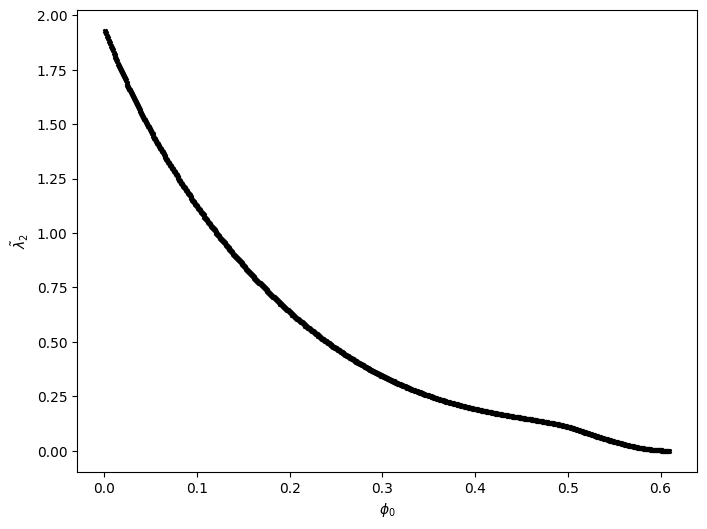

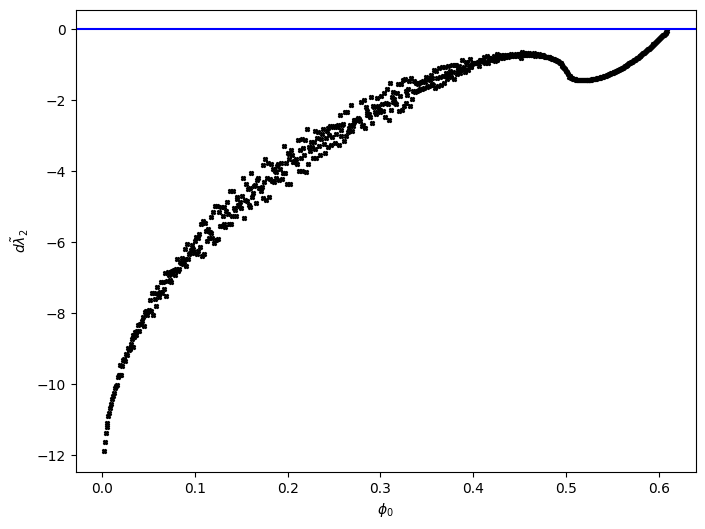

In [48]:
phi_0stoplot = np.arange(0,611)[1:-1]*gap
eigenval_1_sto = []
eigenval_2_sto = []

def eigenstate(phi_0given, ffun, gfun, fpfun, gpfun):
  trace = 3*ffun(phi_0given) - phi_0given*fpfun(phi_0given) + gpfun(phi_0given)
  det = 3*ffun(phi_0given)*gpfun(phi_0given) - 3*gfun(phi_0given)*fpfun(phi_0given)
  # First entry - smaller eigenvalue; Second entry - larger eigenvalue
  return (trace - (max(0,trace**2 - 4*det))**(1/2), trace + (max(0,trace**2 - 4*det))**(1/2))

for p in phi_0stoplot:
  eigenval_1_sto.append(eigenstate(p,ffluxfun,gfluxfun,fpfluxfun,gpfluxfun)[0])
  eigenval_2_sto.append(eigenstate(p,ffluxfun,gfluxfun,fpfluxfun,gpfluxfun)[1])

eigenval_1_sto = np.array(eigenval_1_sto)
eigenval_2_sto = np.array(eigenval_2_sto)



plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, eigenval_1_sto, color = (0,0,0),  marker = 'X', ls='none', ms = 3)
#plt.ylim([0.4,0.6])
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$\tilde{\lambda}_1$')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot[1:], 1/gap*(eigenval_1_sto[1:] - eigenval_1_sto[:-1]), color = (0,0,0),  marker = 'X', ls='none', ms = 3)
#plt.ylim([0.4,0.6])
plt.xlabel(r'$\phi_0$')
plt.axhline(y=0, color='b', linestyle='-')
plt.ylabel(r'$d\tilde{\lambda}_1$')
plt.show()


plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, eigenval_2_sto, color = (0,0,0),  marker = 'X', ls='none', ms = 3)
#plt.ylim([0.4,0.6])
plt.xlabel(r'$\phi_0$')
plt.ylabel(r'$\tilde{\lambda}_2$')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot[1:], 1/gap*(eigenval_2_sto[1:] - eigenval_2_sto[:-1]), color = (0,0,0),  marker = 'X', ls='none', ms = 3)
#plt.ylim([0.4,0.6])
plt.xlabel(r'$\phi_0$')
plt.axhline(y=0, color='b', linestyle='-')
plt.ylabel(r'$d\tilde{\lambda}_2$')
plt.show()




Check Genuine-Nonlinearity

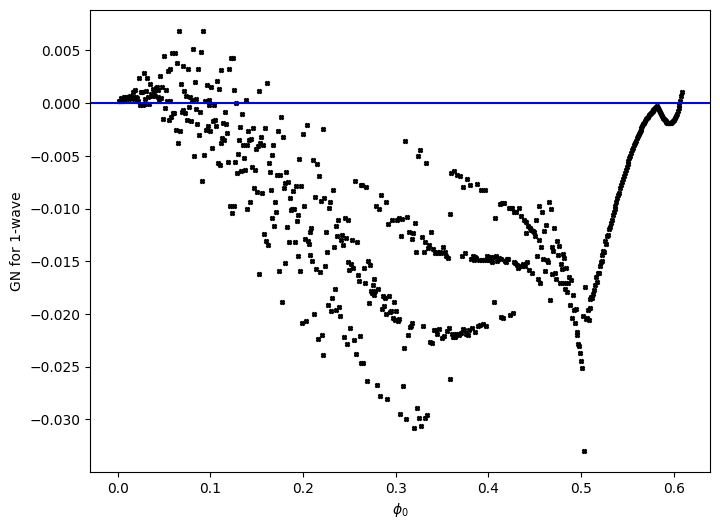

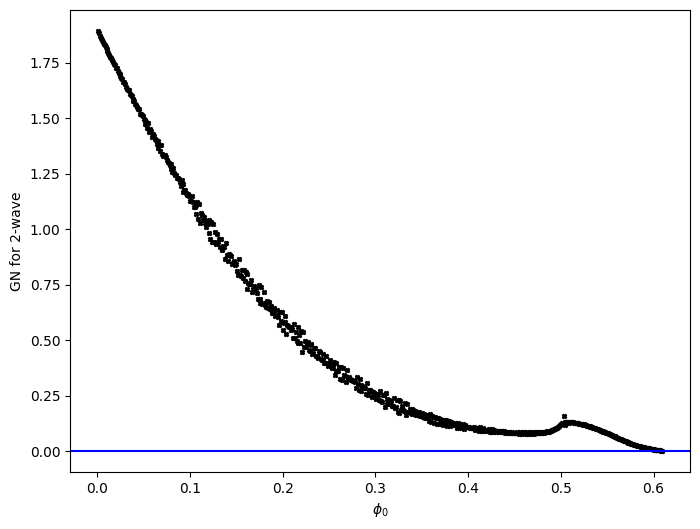

In [46]:
def check_1(phi_0):
    ## Uses global ffluxfun, gfluxfun, fpfluxfun, gpfluxfun, fppfluxfun, gppfluxfun
    ## Checks for validity of genuine nonlinearity for the first wave.
    f, f_p, f_pp = ffluxfun(phi_0), fpfluxfun(phi_0), fppfluxfun(phi_0)
    g, g_p, g_pp = gfluxfun(phi_0), gpfluxfun(phi_0), gppfluxfun(phi_0)
    tr = 3*f - phi_0*f_p + g_p
    disc = np.sqrt(max(0.00001,tr**2 - 12*(f*g_p - g*f_p)))
    lambda_1 = 1/2*(tr - disc**(1/2)) ##
    tr_p = 2*f_p-phi_0*f_pp + g_pp
    disc_p = 2*tr*tr_p - 12*(f*g_pp - g*f_pp)
    lambda_1_p = 1/2*(tr_p - 1/2*disc**(-1/2)*disc_p) ##
    return 2*(lambda_1 - phi_0*lambda_1_p)*(lambda_1 - g_p) + lambda_1_p*(3*g - phi_0*g_p)


def check_2(phi_0):
    ## Uses global ffluxfun, gfluxfun, fpfluxfun, gpfluxfun, fppfluxfun, gppfluxfun
    ## Checks for validity of genuine nonlinearity for the first wave.
    f, f_p, f_pp = ffluxfun(phi_0), fpfluxfun(phi_0), fppfluxfun(phi_0)
    g, g_p, g_pp = gfluxfun(phi_0), gpfluxfun(phi_0), gppfluxfun(phi_0)
    tr = 3*f - phi_0*f_p + g_p
    disc = np.sqrt(max(0.00001,tr**2 - 12*(f*g_p - g*f_p)))
    lambda_2 = 1/2*(tr + disc**(1/2)) ##
    tr_p = 2*f_p-phi_0*f_pp + g_pp
    disc_p = 2*tr*tr_p - 12*(f*g_pp - g*f_pp)
    lambda_2_p = 1/2*(tr_p + 1/2*disc**(-1/2)*disc_p) ##
    return 2*(lambda_2 - phi_0*lambda_2_p)*(lambda_2 - g_p) + lambda_2_p*(3*g - phi_0*g_p)

phi_0stoplot = np.arange(0,611)[1:-1]*gap
wave_1_sto = []
wave_2_sto = []

for p in phi_0stoplot:
  wave_1_sto.append(check_1(p))
  wave_2_sto.append(check_2(p))

wave_1_sto = np.array(wave_1_sto)
wave_2_sto = np.array(wave_2_sto)



plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, wave_1_sto, color = (0,0,0),  marker = 'X', ls='none', ms = 3)
plt.axhline(y=0, color='b', linestyle='-')
#plt.ylim([0.4,0.6])
plt.xlabel(r'$\phi_0$')
plt.ylabel('GN for 1-wave')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(phi_0stoplot, wave_2_sto, color = (0,0,0),  marker = 'X', ls='none', ms = 3)
plt.axhline(y=0, color='b', linestyle='-')
#plt.ylim([0.4,0.6])
plt.xlabel(r'$\phi_0$')
plt.ylabel('GN for 2-wave')
plt.show()

